# Identifying Processes Leading to Metastases

## Nevo Raz & Ofir Katz
April 2020

In [1]:
#basic data analysis packages
import numpy as np
import pandas as pd

#basic data visualization packages
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

# Load Data

**Loading Data** From http://acgt.cs.tau.ac.il/multi_omic_benchmark/download.html (SKCM) and gtex data

Description: 
- exp: gene expression data
- mirna: micro RNA (miRNA) data
- survival: specifying whether the patient sampled died or not
- clinical data -> melanoma: additional clinical information about the patient
- gtex: healthy people skin data (shared by Nimrod via gmail)

In [2]:
# load data
# description: 

"""
creating dict containing 
- filename (of data provided for the project)
- values: [fist column name, dataset name, separator]
"""

data = {'exp':['gene', 'gene_data', ' '], 
        'mirna': ['micro_rna', 'micro_rna_data', ' '],
        'gtex_data': ['ensemble_id', 'gtex_data', '\t']}

dataframes = {}

"""
load_dataframe will add relevant data to dataframes
"""

def load_dataframe(filename, values):
    title_row = pd.read_csv('{}.csv'.format(filename), header=None, nrows=1) #read table column names as row
    names = title_row.iloc[0, 0].replace('"', '').split(values[2]) #create colum title list
    if filename == 'gtex_data':
        names[0] = values[0]
    else:
        names = [values[0]] + names
    dataframes[values[1]] = pd.read_csv('{}.csv'.format(filename), names=names, skiprows=1, sep=values[2]) #read data    

for x in data.keys():
    load_dataframe(x, data[x])
 

In [3]:
# data exploration: delete irrelevant genes from data

# removing rows from 'exp' where genes begin in "X.." (following discussion with Nimrod, they are irrelevant)
dataframes['gene_data'] = dataframes['gene_data'][~dataframes['gene_data'].gene.str.contains("X..")] 

In [4]:
# data exploration: delete irrelevant samples from data

#sample types should be '01' or '06', but data exploration showed us that some other samples exist
def delete_irrelevant_samples(dataframe, title):
    sample_types = [x[-2:] for x in dataframe.columns[1:]]
    columns_to_remove = []
    for x in range(len(sample_types)):
        if sample_types[x] not in ['01', '06']:
            columns_to_remove.append(dataframe.columns[x + 1])
    print("removing following columns from {}:".format(title), columns_to_remove)
    dataframe = dataframe.drop(columns=columns_to_remove)
    return dataframe

dataframes['gene_data'] = delete_irrelevant_samples(dataframes['gene_data'], "gene expression data")
dataframes['micro_rna_data'] = delete_irrelevant_samples(dataframes['micro_rna_data'], "micro RNA data")

removing following columns from gene expression data: ['TCGA.D3.A1QA.07', 'TCGA.GN.A4U8.11']
removing following columns from micro RNA data: ['TCGA.D3.A1QA.07', 'TCGA.FW.A3R5.11', 'TCGA.GN.A4U8.11']


In [5]:
# load survival data

"""
survival data needs to be loaded in a different way (based on data observation)
we will load it and add it to our dataframes dictionary (for consistency)

the column named "Death" has been renamed as "isDead" for clarity
"""
survival = pd.read_csv('survival.csv', names=['PatientID', 'Survival', 'isDead'], skiprows=1, sep='\t')

dataframes['survival_data'] = survival

In [6]:
# load clinical data data (clinical data -> melanoma)

"""
loading with python or excel: problem with rwos 38, 39!!

the data has a problem in line 38, 39:
they are series with 3 elements (total values: 105, unlike total 103 in other rows)
we discluded this data

we tried to load this data with RStudio but it didnt work
"""

clinical_titles = pd.read_csv('melanoma.txt', header=None, nrows=1) 
clinical_data_titles = clinical_titles.iloc[0, 0].split('\t')

clinical_data = pd.read_csv('melanoma.txt', header=None, names=clinical_data_titles, skiprows=[0, 38,39], sep='\t') 

dataframes['clinical_data'] = clinical_data

# Normalize Data

**Normalize Gene Expression and Micro RNA Data**

Steps: 
1. perform log2(val + 1)
2. remove features with low variance (we chose to remove values with variance below the 45th percentile)
3. subtract mean and divide by std

**Normalize GTEX data**

Steps: 
1. check if data is normalized or partially normalized (--> we discovered values were between 0 and 1, the mean was already 0, the std was not 1)
2. normalize if necessary based on missing steps (--> only divide by std)

**<u>Gene Expression and Micro RNA Normalization</u>**

In [7]:
def perform_log(dataframe, column_name):
    # perform log2 (val+1)
    dataframe = dataframe.apply(lambda x: np.log2(x + 1) if x.name != column_name else x)
    return dataframe

def remove_low_variance_features(dataframe, percentile_to_remove):
    # find variance per row
    dataframe['std'] = dataframe.std(axis=1)
    # find relevant quantile for variance column
    quantile_value = dataframe['std'].quantile(percentile_to_remove)
    # retain only rows with variance greater than selected quantile
    dataframe = dataframe[dataframe['std'] > quantile_value]
    # drop current varinace column in order to not interfere in future calcuations on full rows
    dataframe = dataframe.drop(['std'], axis=1)
    return dataframe

def subtract_mean_divide_std(dataframe):
    # find mean per row
    mean_vals = dataframe.mean(axis=1) #these are the expected values
    # replace zero vals with row mean in order for df to keep 0 values
    # dataframe = dataframe.mask(dataframe == 0, mean_vals, axis=0)
    # find std per row
    std_vals = dataframe.std(axis=1) #this is the variance
    # subtract means and divide by std
    dataframe.iloc[:, 1:] = dataframe.iloc[:, 1:].subtract(mean_vals, axis=0).divide(std_vals, axis=0)
    return dataframe    

"""
normalize data gets 
- a dataframe
- the name of the first column of the dataframe
- the percentile of variance values below which to remove features (to remove features with low variance)
"""
def normalize_data(dataframe, column_name, percentile_to_remove):
    dataframe = perform_log(dataframe, column_name)
    dataframe = remove_low_variance_features(dataframe, percentile_to_remove)
    dataframe = subtract_mean_divide_std(dataframe)
    return dataframe


# check if datasets are normalized
def check_if_normalized(dataframe, data_description):
    print("checking {}:".format(data_description))
    max_mean = round(dataframe.mean(axis = 1), 1).max()
    min_mean = round(dataframe.mean(axis = 1), 1).min()
    max_std = round(dataframe.std(axis = 1), 1).max()
    min_std = round(dataframe.std(axis = 1), 1).min()
    # max/min mean values
    print("\nmean:")
    print("max value: ", max_mean)
    print("min value: ", min_mean)
    # max/min std values
    print("\nstd:")
    print("max value: ", max_std)
    print("min value: ", min_std)
    if max_mean == 0 and min_mean == 0:
        print("\nmean result is correct")
    else:
        print("\nmean result is not correct")
    if max_std == 1 and min_std == 1:
        print("\nstd result is correct")
    else:
        print("\nstd result is not correct")

In [8]:
dataframes['gene_data'] = normalize_data(dataframes['gene_data'], 'gene', 0.45)
dataframes['micro_rna_data'] = normalize_data(dataframes['micro_rna_data'], 'micro_rna', 0.45)

In [9]:
check_if_normalized(dataframes['gene_data'], "gene expression data")

checking gene expression data:

mean:
max value:  -0.0
min value:  -0.0

std:
max value:  1.0
min value:  1.0

mean result is correct

std result is correct


**<u>GTEX Normalization</u>**

In [10]:
# check if gtex is normalized: nimrod didn't know if the data was already normalized or needed additions

check_if_normalized(dataframes['gtex_data'], "gtex data")

checking gtex data:

mean:
max value:  -0.0
min value:  -0.0

std:
max value:  1.4
min value:  0.0

mean result is correct

std result is not correct


In [11]:
# these results mean that we have to partially normalize gtex_data: we'll divide each row by its std

def normalize_gtex(dataframe):
    std_vals = dataframe.std(axis=1)
    dataframe.iloc[:, 1:] = dataframe.iloc[:, 1:].divide(std_vals, axis=0)
    return dataframe    

dataframes['gtex_data'] = normalize_gtex(dataframes['gtex_data'])

In [12]:
# check if gtex is normalized now
check_if_normalized(dataframes['gtex_data'], "gtex data")

checking gtex data:

mean:
max value:  -0.0
min value:  -0.0

std:
max value:  1.0
min value:  1.0

mean result is correct

std result is correct


# Methods Used

**CLUSTERING**

**What is clustering?**
Clustering is a technique to group similar data points in a way that places more similar points in the same group.
A cluster is a group of similar points.

In the following project we will use 2 clustering methods:
1. <u>Hierarchical Clustering</u>
2. <u>K-means Clustering</u>

**Hierarchical Clustering**

There are 2 types of hierarchical clustering, agglomerative and divisive.
- <u>agglomerative</u>: data points are clustered using a bottom-up approach starting with individual data points
- <u>divisive</u>: data points are clustered using top-down approach 

In this project, we will use the agglomerative technique: the clustering works as follows:
1. Each data point will be considered a separate cluster (we will have k clusters for k data points)
2. The two closest data points will be joined, creating k-1 clusters
3. Keep iteratively joining the two closest clusters until we get one cluster

The clustering results can be visualized using a **dendrogram**

**Hierarchical Clustering Methods:**

we will describe 3 methods, that according to our research are the most commonly used methods in studies, though more methods exist:

1. <u>complete/max/farthest neighbor</u>: the distance between two clusters is defined as the longest distance between two points in each cluster.
2. <u>average</u>: the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster.
3. <u>ward/minimal increase of sum-of-squares</u>: uses ward's method: similar to average, but using the sum of the square of the distances. Proximity between two clusters is the magnitude by which the summed square in their joint cluster will be greater than the combined summed square in these two clusters.

<u>How can we select a method to use?</u>
- One possibility is to use the to calculate the cophenet, because the correlation between the distance matrix and the cophenetic distance can help suggest clustering method to choose. We want to select the method where the correlation between the original distances and the cophenetic distances is high.

<span style="color:red">
**K-Means Clustering**
TODO: Nevo
</span>

**PCA**

**What is PCA?** 
- Principal Component Analysis (PCA) is a statistical procedure used to convert a set of observations with multiple dimensions (features, variables) that might be correlated into a group of linearly uncorrelated variables (principal components) using orthogonal tranformation.
- PCA reduces the dimensions of the fetaures spaces, in a way where new variables are orthogonal 

PCA works as follows:
<span style="color:red">
TODO: use this: https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c
</span>

**Selecting the Number of Principal Components**
<span style="color:red">
TODO: read about this, examples that are not great:
    https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21
    kaggle notebook: https://www.kaggle.com/ofirkatz/principle-component-analysis-gene-expression/edit
</span>
**Methods for Examining Variance of PCs**
<span style="color:red">
TODO: many sources about this suck
</span>

PCA is unsupervised method and it’s difficult to interpret the two axes as they are some complex mixture of the original features.

# Data Analysis

Research Questions and Analysis Methodology:

<u>Question # 1</u>

**Q: If we look at gene expression data of primary tumors and metastases together, is there a clear distinction between them? Does such a distinction exist for micro RNA?**

***Analysis Description:*** 

the following process will be performed once with gene expression data and once with miRNA data:

- A method for clustering was selected by comparing the cophenet of 3 possible methods: 'ward', 'complete', 'average'
- Clustering was be performed by sample (01, 06 samples) using 2 separate methods
- Results of clustering were displayed using a dendrogram (a useful tool to display biological clustering)
- Results of clustering were analyzed as follows:
    - Clustering results were examined for k # of clusters = [2, 4, 10, 15, 25, / 35, 45] (additionals for miRNA)
    - Per k, each cluster was examined:
        - We checked if the cluster has resulted in a higher percent of actual 01 samples / actual 06 samples
        - Based on the analysis, we defined each cluster as 'primary', 'metastasis' or 'unknown'
- We selectd one of the clustering methods for a specific k for further analysis 
    - for gene expression: k = 15, method = 'complete'
    - for miRNA: k = 45, method = 'ward'
- We displayed the data matrix graphically as a scatter plot in 2D (this shouldn't make much sense because data is multi-dimensional, but gives a good understanding of data point types and the quality of clustering)
    1. one graph is displayed by actual 01/06 sample
    2. one graph is displayed by cluster
    3. one graph is displayed by 01/06 sample **based on clustering results**
- We performed PCA to find new axis (PC1, PC2, PC3) to display our data on
    - we normalized the data so that all data points are between 0 and 1
    - we performed analysis of a how many components to use for the PCA
    - we performed PCA for number of components selected
        - for gene expression: n_components = 300
        - for miRNA: n_components = 250
    - we calculated the explained variance % per PC and specifically examined the % for PCs 1, 2 and 3
    - we graphed the data in 2D (PC1 as x, PC2 as y) and in 3D ((PC1 as x, PC2 as y, PC3 as z)
        1. one graph section displayed the data points colored by actual sample type (primary, metastasis) based on sample name 
        2. one graph section displayed the data points colored by cluster
        3. one graph section displayed the data points colored by cluster sample type (primary, metastasis, unknown) **based on clustering results**
    

In [13]:
# imports for hierarchial clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist

# imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# imports for plotting
import plotly.graph_objs as go
import plotly.offline as offline
from mpl_toolkits.mplot3d import Axes3D  

Question 1: Gene Expression Analysis

In [14]:
#transpose data to get a matrix of samples for rows, dimensions (genes) for columns

def transform_data(dataframe):
    a = dataframe.T
    a.columns = a.iloc[0]
    a = a.iloc[1:, :]
    X = a.to_numpy() # convert a to numpy array (no row, column names) because algos we will use need this
    return a, X
    
a, X = transform_data(dataframes['gene_data'])

a.head()

gene               A1BG.1 A2BP1.54715 A2LD1.87769 A2ML1.144568     A2M.2  \
TCGA.3N.A9WB.06  0.703106   -0.413022     1.75643     0.219317  -2.15274   
TCGA.3N.A9WC.06 -0.271476   -0.413022     1.03666    -0.712711   1.85089   
TCGA.3N.A9WD.06  0.623738     2.57316    0.220533    -0.712711 -0.204097   
TCGA.BF.A1PU.01 -0.418624    0.830254     1.06153     0.246341  -1.12695   
TCGA.BF.A1PV.01 -0.118319   -0.413022   -0.534805    -0.505992  -2.37279   

gene            A4GALT.53947 AACSL.729522 AADACL2.344752 AADACL3.126767  \
TCGA.3N.A9WB.06      -1.0512    -0.634155       0.939575       -0.16196   
TCGA.3N.A9WC.06     0.140153    -0.415142      -0.344445       -0.16196   
TCGA.3N.A9WD.06     0.816695   -0.0611561      -0.344445       -0.16196   
TCGA.BF.A1PU.01     0.450017    -0.634155       0.260928       -0.16196   
TCGA.BF.A1PV.01    -0.964558    -0.634155      -0.344445       -0.16196   

gene            AADAC.13  ... ZSCAN18.65982 ZSCAN1.284312 ZSCAN23.222696  \
TCGA.3N.A9WB.06 -0.53831  ...     -0.690519     -0.697552       -1.12202   
TCGA.3N.A9WC.06 -0.53831  ...       1.47795     0.0771556      -0.366684   
TCGA.3N.A9WD.06 -0.53831  ...       1.32464      0.463101      -0.571297   
TCGA.BF.A1PU.01 -0.53831  ...       1.16722     -0.327994       0.474251   
TCGA.BF.A1PV.01 -0.53831  ...       1.14218     -0.353843       -1.17547   

gene            ZSCAN4.201516 ZSCAN5A.79149 ZSCAN5B.342933 ZSWIM5.57643  \
TCGA.3N.A9WB.06      -0.64468      -1.51789       -1.15626    0.0902101   
TCGA.3N.A9WC.06      -0.64468      0.113756      -0.628801    -0.580616   
TCGA.3N.A9WD.06     0.0615025      0.738158       0.223716      1.56847   
TCGA.BF.A1PU.01      -0.64468     -0.661544       -1.15626     0.201055   
TCGA.BF.A1PV.01      -0.64468     0.0867665      -0.747601     -1.92418   

gene            ZUFSP.221302 ZYG11A.440590 psiTPTE22.387590  
TCGA.3N.A9WB.06    -0.141193        0.9863        -0.876562  
TCGA.3N.A9WC.06    0.0554014     -0.435242        -0.520554  
TCGA.3N.A9WD.06     0.104382       1.63676          2.47852  
TCGA.BF.A1PU.01    0.0906005     -0.985369        -0.929176  
TCGA.BF.A1PV.01    -0.216158     -0.985369         -1.14425  

[5 rows x 10650 columns]

In [15]:
# defining sample labels with only "06", "01" for clarity     
samples_label_list = [x[-2:] for x in list(a.index)]

In [16]:
# selecting clustering methods for use

def select_clustering_method(data_matrix, method_list):
    print("method; cophenet;")
    for method in method_list:
        l = linkage(data_matrix, method=method)
        c, coph_dists = cophenet(l, pdist(data_matrix))
        print(method, c)

select_clustering_method(X, ['complete', 'average', 'ward'])
    
# select optimal linkage method: chopenet should be closest to 1   
# methods selected: 'complete' and 'average'

method; cophenet;
complete 0.5378570666061107
average 0.7461720517220348
ward 0.4547375338222622


In [17]:
# cluster gene expression by samples (primary vs metastasis) and plot resulting dendrogram

def cluster_by_sample_and_plot_dendrogram(data, labels, method):
    plt.figure(figsize=(25, 10)) # define figure size
    plt.title('Hierarchical Clustering Dendrogram, Method: {} - Cluster By Sample'.format(method.capitalize())) # add figure title
    plt.xlabel('samples') # label x axis
    plt.ylabel('distance') # label y axis
    samples_dist = pdist(data) # computing the distance
    samples_link = linkage(samples_dist,  metric='correlation', method=method) # computing the linkage
    dendrogram(samples_link,labels=labels)
    plt.show()
    return samples_link # return the linkage, it is needed for additional functions

# divide sample results of dendrogram into k clusters
def divide_samples_into_clusters(k, samples_link, samples_label_list):
    fl = fcluster(samples_link, k,criterion='maxclust') # list leaves by cluster      
    sample_clusters = fl.tolist() # sample_clusters will be a list of cluster numbers (1-k)
    sample_cluster_dict = {} # based on cluster results, create dict mapping to a list of samples in each cluster
    for num in range(1, k+1):
        sample_cluster_dict[num] = [] # initialize k empty lists in dict
    for x in range(len(sample_clusters)):
        sample_cluster_dict[sample_clusters[x]].append(samples_label_list[x]) # add the relevent label from samples_label_list to cluster list
    return sample_cluster_dict

# for each cluster, check if it is mostly 01 or 06 and print out results
def analyze_sample_clusters(sample_cluster_dict):
    print("\nk = {}".format(len(sample_cluster_dict)))
    print("cluster\t\tcluster_type\t\tprimary_cases\tmetastasis_cases\ttotal_cases")   
    for key in sample_cluster_dict.keys(): # perform per cluster
        num_01 = num_06 = 0
        for element in sample_cluster_dict[key]: # count 01, 06 elements in cluster
            if element == '01':
                num_01+= 1
            elif element == '06':
                num_06+= 1
        total = num_01 + num_06 # total number of elements in cluster
        if total > 0:
            num_01 = (num_01/total)*100 # percent of 01 in cluster
            num_06 = (num_06/total)*100 # percent of 06 in cluster
            if round(num_01, 2) > round(num_06, 2): # greater percent of 01 is primary clsuter
                cluster_type = 'primary (01)'
            elif round(num_01, 2) < round(num_06, 2): # greater percent of 06 is metastasis clsuter
                cluster_type = 'metastasis (06)'
            else: # if the percent is equal, this cluster type is unknown
                cluster_type = 'unclear    '
            print("{}\t\t{}\t\t{}%\t\t{}%\t\t\t{}".format(key, cluster_type, round(num_01, 2), round(num_06, 2), total))

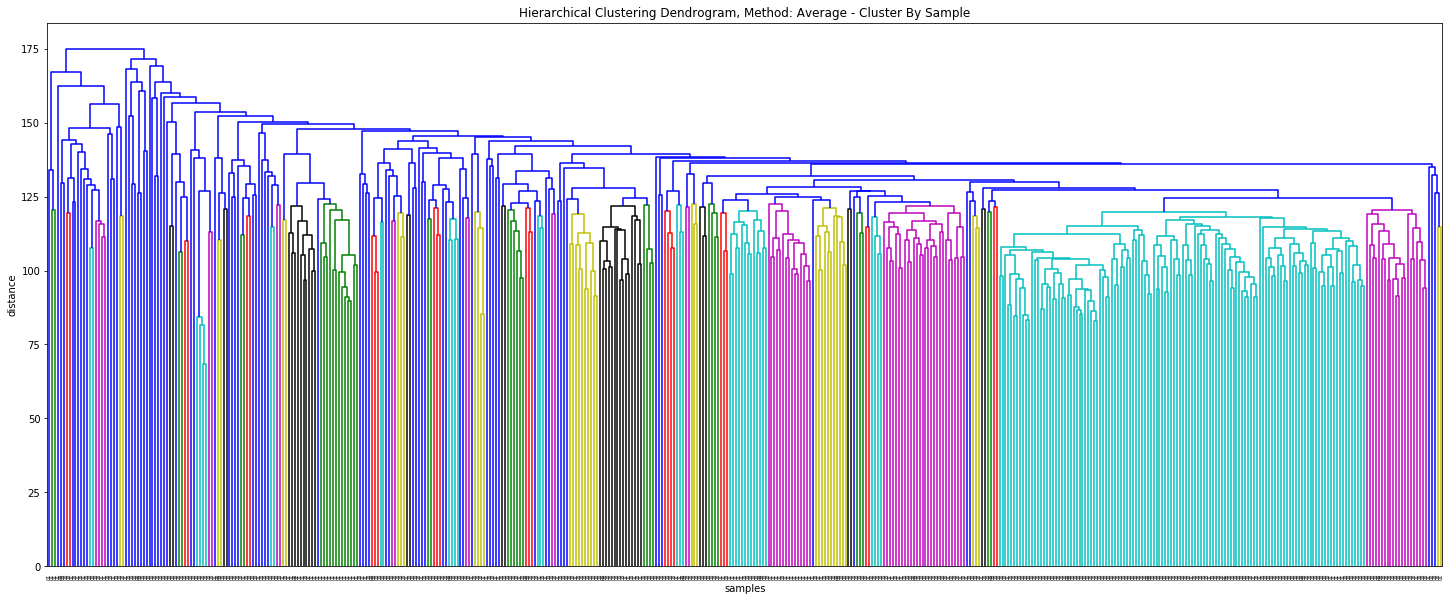


k = 2
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		38.46%		61.54%			26
2		metastasis (06)		20.9%		79.1%			445

k = 4
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		38.46%		61.54%			26
2		metastasis (06)		12.5%		87.5%			8
3		metastasis (06)		21.1%		78.9%			436
4		metastasis (06)		0.0%		100.0%			1

k = 10
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		primary (01)		100.0%		0.0%			3
2		metastasis (06)		27.27%		72.73%			22
3		primary (01)		100.0%		0.0%			1
4		metastasis (06)		0.0%		100.0%			3
5		metastasis (06)		0.0%		100.0%			2
6		metastasis (06)		0.0%		100.0%			2
7		primary (01)		100.0%		0.0%			1
8		metastasis (06)		0.0%		100.0%			3
9		metastasis (06)		21.25%		78.75%			433
10		metastasis (06)		0.0%		100.0%			1

k = 15
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		primary (01)		100.0%		0.0%			3
2		metastasis (06)		31.58%		68.42%			19
3		metastasis (06)		0.0%		100.0

In [18]:
### Clustering with 'average' method ###

# cluster and plot dendrogram with 'average' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'average')

# choose best k for 'average' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

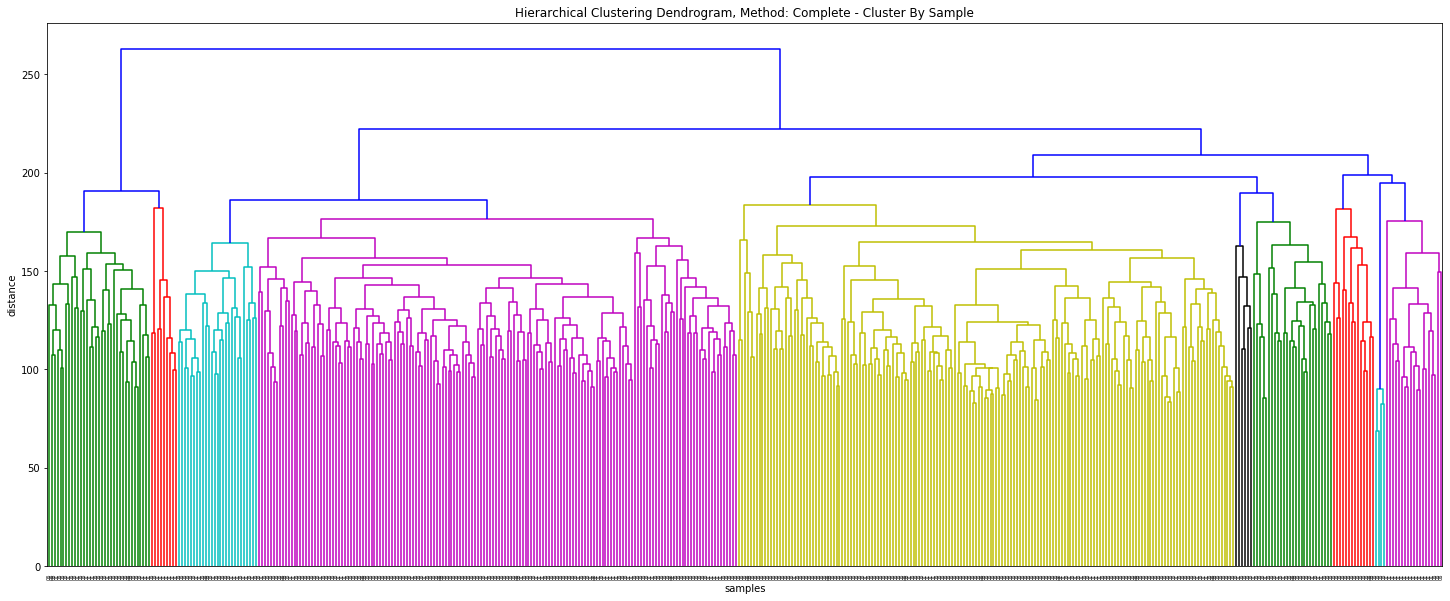


k = 2
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		38.64%		61.36%			44
2		metastasis (06)		20.14%		79.86%			427

k = 4
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		38.64%		61.36%			44
2		metastasis (06)		22.22%		77.78%			189
3		metastasis (06)		13.93%		86.07%			201
4		metastasis (06)		43.24%		56.76%			37

k = 10
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		28.57%		71.43%			35
2		primary (01)		77.78%		22.22%			9
3		metastasis (06)		33.33%		66.67%			27
4		metastasis (06)		20.37%		79.63%			162
5		metastasis (06)		11.9%		88.1%			168
6		metastasis (06)		16.67%		83.33%			6
7		metastasis (06)		25.93%		74.07%			27
8		metastasis (06)		0.0%		100.0%			14
9		metastasis (06)		0.0%		100.0%			4
10		primary (01)		84.21%		15.79%			19

k = 15
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		28.57%		71.43%			35
2		metastasis (06)		0.0%		100.0%			

In [19]:
### Clustering with 'complete' method ###

# cluster and plot dendrogram with 'complete' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'complete')

# choose best k for 'complete' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

In [20]:
# select clustering method

# set chosen k based on previous analysis and chosen method
k = 25

# define clusters
clusters = fcluster(samples_link, k, criterion='maxclust')

In [21]:
# scatter plot of clusters

# this function takes a data matrix and plots its points
# results shouldn't make much sense because we have many dimensions!
def scatter_plot_samples(data, color_values, title):
    plt.figure(figsize=(25, 7)) # set figure size
    plt.title(title) # set title
    plt.xlabel('genes expression value') # label x axis
    plt.ylabel('samples') # label y axis
    plt.scatter(data[:,0], data[:,1], c=color_values, cmap='prism')
    plt.show()

In [22]:
def define_cluster_types(dataset, k, samples_link, clusters):
    samples_full_label_list = list(dataset.index)
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_full_label_list)    
    cluster_types = []
    for key in sample_cluster_dict.keys():
        num_01 = num_06 = 0
        for element in sample_cluster_dict[key]:
            if element[-2:] == '01':
                num_01+= 1
            elif element[-2:] == '06':
                num_06+= 1
        total = num_01 + num_06
        if total > 0:
            num_01 = (num_01/total)*100
            num_06 = (num_06/total)*100
            if round(num_01, 2) > round(num_06, 2):
                cluster_types.append((key, 'primary'))
            elif round(num_01, 2) < round(num_06, 2):
                cluster_types.append((key, 'metastasis'))
            else: 
                cluster_types.append((key, 'unknown'))
    primary_metastasis_cluster_list = []
    for cluster in clusters:
        if cluster_types[cluster-1][1] == 'primary':
            primary_metastasis_cluster_list.append(1)
        elif cluster_types[cluster-1][1] == 'metastasis':
            primary_metastasis_cluster_list.append(6)
        else:
            primary_metastasis_cluster_list.append(0)
    return cluster_types, primary_metastasis_cluster_list

cluster_types, primary_metastasis_cluster_list = define_cluster_types(a, k, samples_link, clusters)
primary_metastasis_clusters = np.asarray(primary_metastasis_cluster_list, dtype=np.int32)

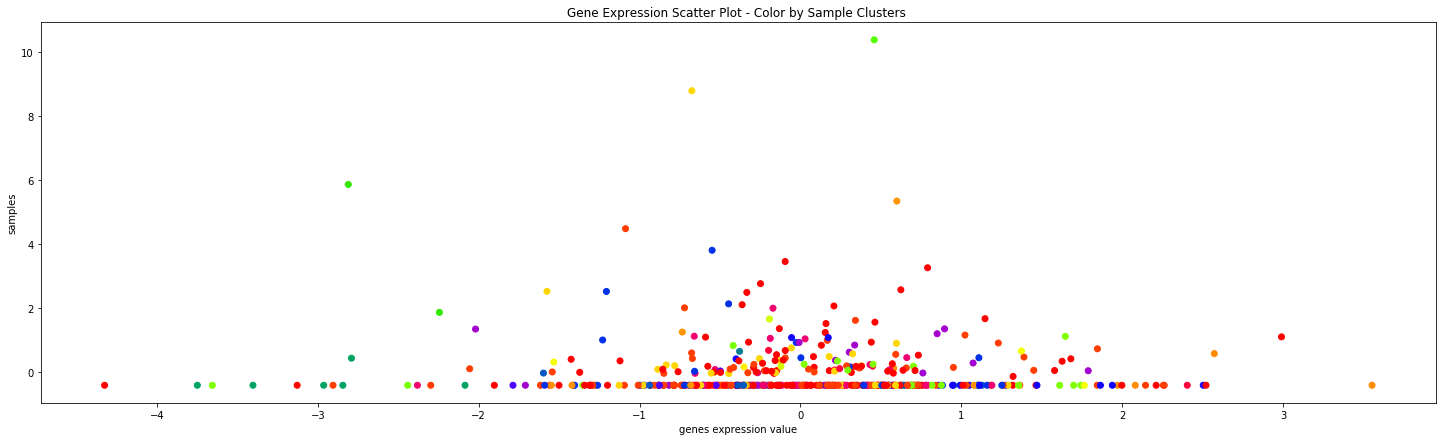

In [23]:
# 1. plot points with color by cluster
scatter_plot_samples(X, clusters, 'Gene Expression Scatter Plot - Color by Sample Clusters ')

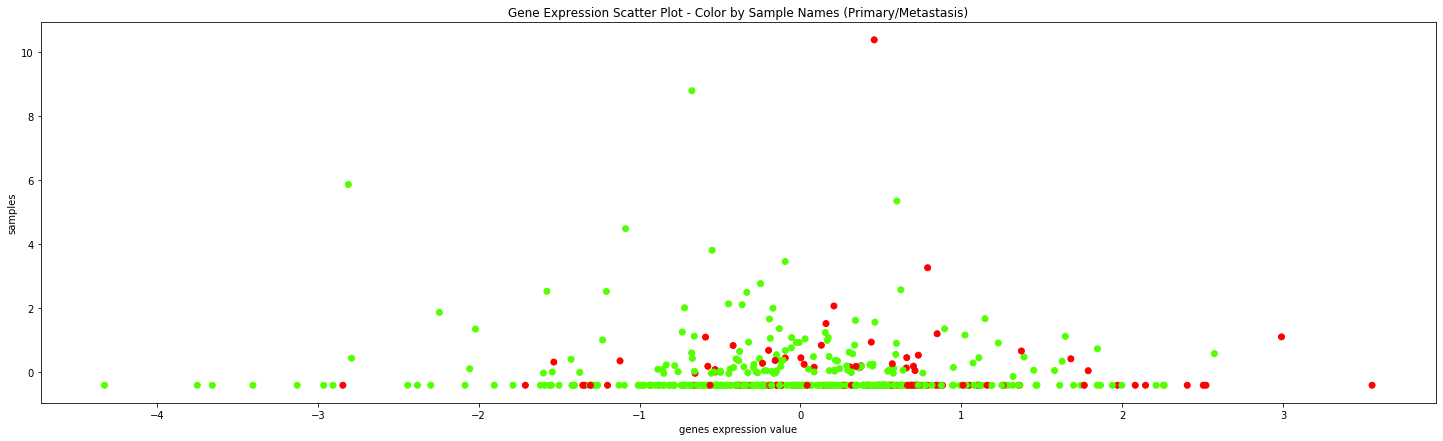

In [24]:
# 2. plot points with color by sample name (01 or 06) (actual tumor type: primary or metastasis)

color_values = np.asarray(samples_label_list, dtype=np.int32)
scatter_plot_samples(X, color_values, 'Gene Expression Scatter Plot - Color by Sample Names (Primary/Metastasis)')

# the green point a sample where the name is actually 07! We assumend that this is an 06 sample in clustring

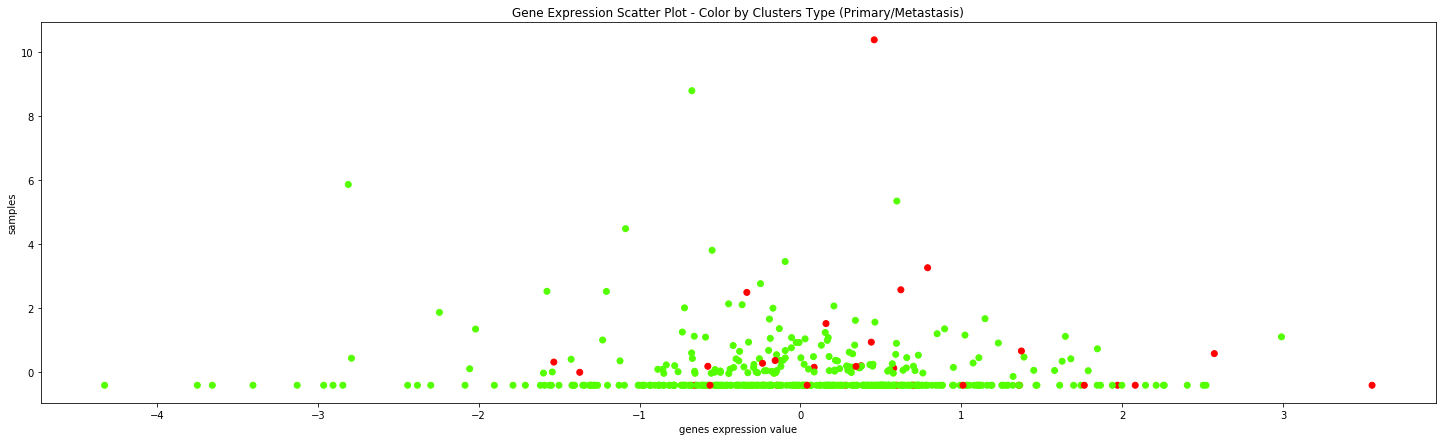

In [25]:
# 3. plot points with color by cluster tumor type (tumor typea as a result of clustering)
scatter_plot_samples(X, primary_metastasis_clusters, 'Gene Expression Scatter Plot - Color by Clusters Type (Primary/Metastasis)')

In [26]:
# Perform PCA in order to display data points on PCs

In [27]:
# normalize data to values between 0 and 1

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X)

print("data has been rescaled")
print("after rescaling: min={}, max={}".format(round(data_rescaled.min(), 2), round(data_rescaled.max(), 2)))

data has been rescaled
after rescaling: min=0.0, max=1.0


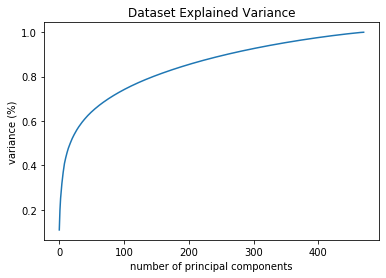

based on graph: selecting 300 principal components that appear to account for 90% of the variance


In [28]:
# Select number of principal components to use for PCA

# the function plots the explained variance for each attribute
def plot_explained_variance(data):
    pca = PCA().fit(data_rescaled) # fitting PCA with our data
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of principal components')
    plt.ylabel('variance (%)') #for each component
    plt.title('Dataset Explained Variance')
    plt.show()
    
plot_explained_variance(data_rescaled)

# based on this graph we need to decide how many principal components to use
# we will not select the maximum possible, in order to preserve only principal components
# however, we want to select a number of components where the graph slope is not very big

# we will decide to use 300 principal components

print("based on graph: selecting 300 principal components that appear to account for 90% of the variance")

In [29]:
# functions for PCA and understanding explained varinace of PCs

def plot_explained_variance_and_cumsum(components, var_exp, cum_var_exp):
    # plot the explained variance
    x = ["PC%s" %i for i in range(1, components)]
    trace1 = go.Bar(x = x , y = list(var_exp), name = "explained variance")
    trace2 = go.Scatter(x = x, y = cum_var_exp, name = "cumulative variance")
    layout = go.Layout(title = 'Explained Variance', xaxis = dict(title = 'principle components', tickmode = 'linear'))
    data = [trace1, trace2]
    fig = go.Figure(data = data, layout = layout)
    offline.iplot(fig)
    
def perform_pca_and_plot_explained_variance(original_data, rescaled_data, components):
    pca = PCA(n_components=components) 
    dataset = pca.fit_transform(rescaled_data)
    Y = pca.fit(original_data)
    var_exp = Y.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    plot_explained_variance_and_cumsum(components, var_exp, cum_var_exp)
    return dataset

In [30]:
# perform PCA with 300 components

components = 300

print("plotting the explained variance per principal component")
dataset = perform_pca_and_plot_explained_variance(X, data_rescaled, components)

# based on the graph, we can see that: 
# PC1 + PC2 are responsible for nearly 21% of the explained variance
# PC1 + PC2 + PC3 are responsible for nearly 26% of the explained variance
# we will use these 3 PCs to graph the points on these axis

plotting the explained variance per principal component


In [31]:
# PC1 + PC2 are responsible for 21% of the explained variance

In [32]:
def add_cluster_info_to_dataset(a, clusters, cluster_types):
    a['tumor_type'] = np.asarray(['primary' if x[-2:] == '01' else 'metastasis' for x in list(a.index)])
    a['cluster'] = clusters
    a['tumor_type_by_clustering'] = np.asarray([cluster_types[x-1][1] for x in clusters])
    
add_cluster_info_to_dataset(a, clusters, cluster_types)

In [33]:
# plotting graphs with PCs as axes


def plot_2D(dataset, labels, colors, labl, title, marker=None, alpha=None):
    # Plot PCA1 and PCA2 by primary, metastasis (samples)
    Xax = dataset[:,0]
    Yax = dataset[:,1]
    labels = labels
    cdict = colors
    labl = labl
    if marker and alpha:
        marker = marker
        alpha = alpha
    fig,ax=plt.subplots(figsize=(10,10))
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        if marker and alpha:
            ax.scatter(Xax[ix], Yax[ix], c = cdict[l], s = 40, label = labl[l], marker = marker[l], alpha = alpha[l])
        else:
            ax.scatter(Xax[ix], Yax[ix], s = 40, label = labl[l])
    plt.xlabel("first principal component (PC1)")
    plt.ylabel("second principal component (PC2)")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_3D(dataset, labels, colors, labl, title, marker=None, alpha=None):
    # Plot PCA1, PCA2 and PCA3 by clusters for k
    Xax = dataset[:,0]
    Yax = dataset[:,1]
    Zax = dataset[:,2]
    labels = labels
    cdict = colors
    labl = labl
    if marker and alpha:
        marker = marker
        alpha = alpha
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        if marker and alpha:
            ax.scatter(Xax[ix], Yax[ix], Zax[ix], c = cdict[l], s = 40, label = labl[l], marker = marker[l], alpha = alpha[l])
        else:
            ax.scatter(Xax[ix], Yax[ix], Zax[ix], s = 40, label = labl[l])
    ax.set_xlabel('first principal component (PC1)')
    ax.set_ylabel('second principal component (PC2)')
    ax.set_zlabel('third principal component (PC3)')
    plt.title(title)
    plt.show()

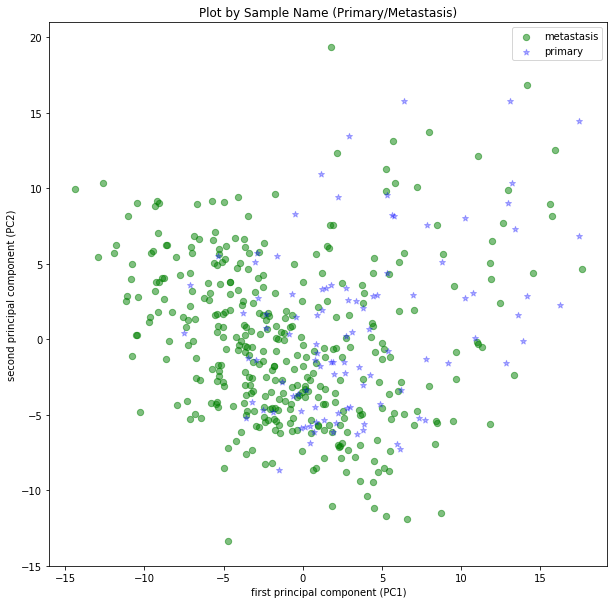

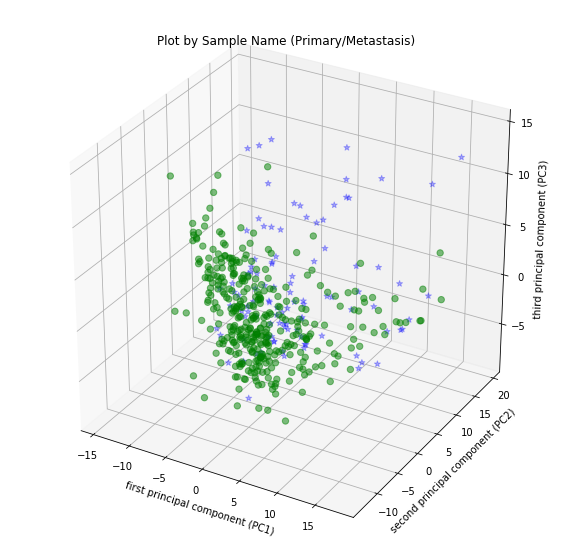

In [34]:
## 2D plot on PC1, PC2 by sample name (primary = 01, metastasis = 06) ##

marker = {'primary':'*','metastasis':'o'}
alpha = {'primary':.3, 'metastasis':.5}

plot_2D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastasis':'green'}, 
        {'primary':'primary','metastasis':'metastasis'},
        "Plot by Sample Name (Primary/Metastasis)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 by sample name (primary = 01, metastasis = 06) ##

plot_3D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastasis':'green'},
        {'primary':'primary','metastasis':'metastasis'},
        "Plot by Sample Name (Primary/Metastasis)",
        marker,
        alpha,)

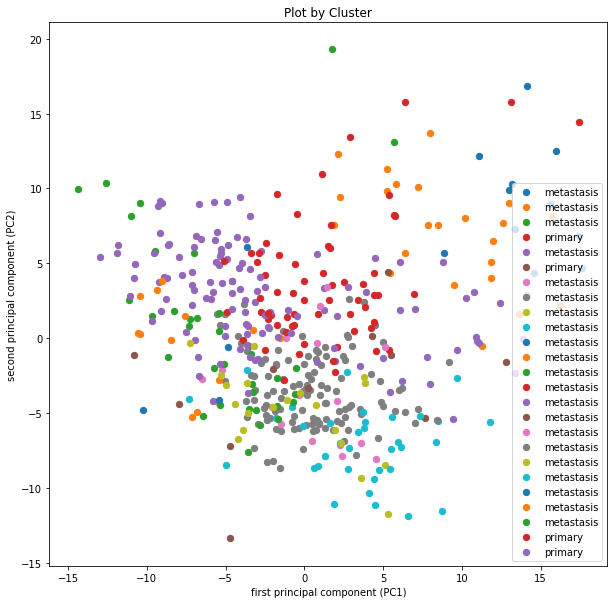

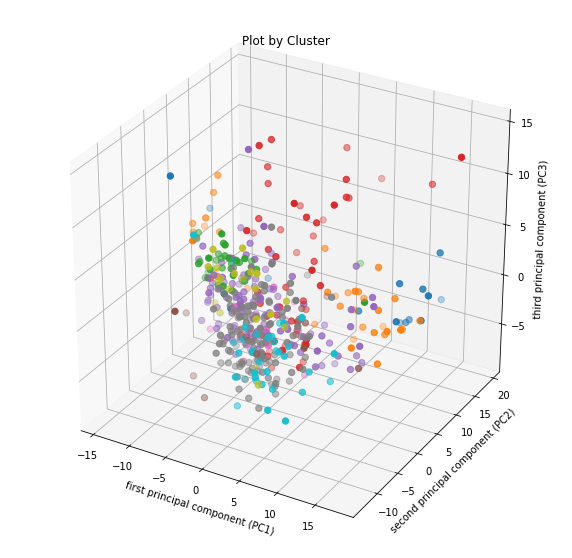

In [35]:
# specify labels
labl_dict = {}
for x in range(1, k+1):
    labl_dict[x] = cluster_types[x-1][1]


## 2D plot on PC1, PC2 by clustering results ##

plot_2D(dataset, a.cluster, a.cluster, labl_dict, "Plot by Cluster")

## 3D plot on PC1, PC2, PC3 by clustering results ##

plot_3D(dataset, a.cluster, a.cluster, labl_dict, "Plot by Cluster")


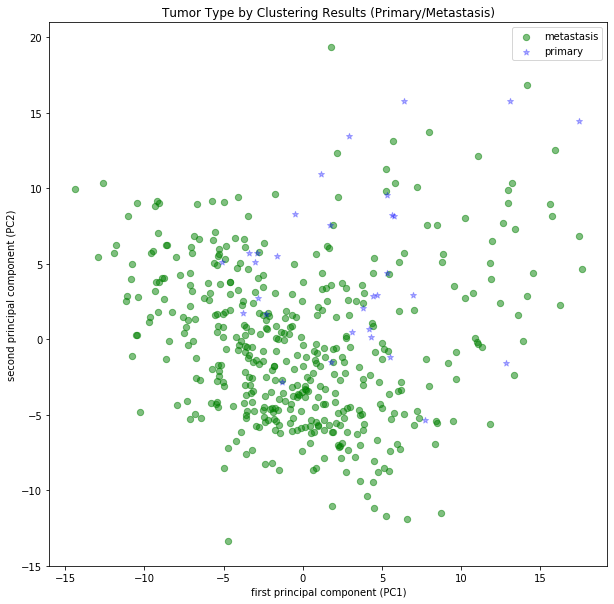

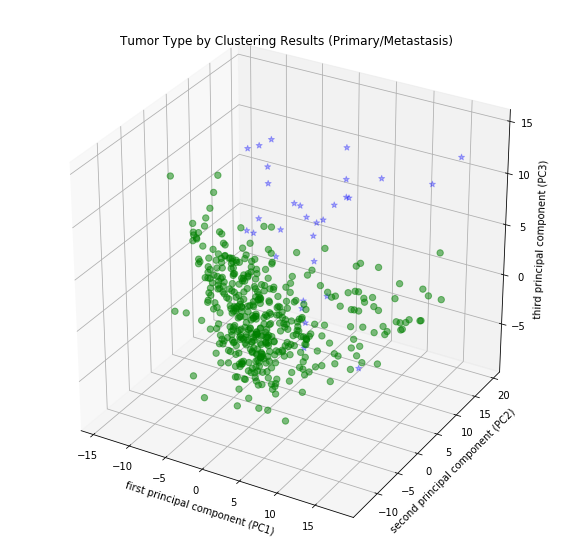

In [36]:
# specify labels

marker = {'primary':'*','metastasis':'o', 'unknown':'.'}
alpha = {'primary':.3, 'metastasis':.5, 'unknown':.2}

## 2D plot on PC1, PC2 tumor type by clustering results ##

plot_2D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastasis':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastasis':'metastasis', 'unknown':'unknown'}, 
        "Tumor Type by Clustering Results (Primary/Metastasis)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 tumor type by clustering results ##
plot_3D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastasis':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastasis':'metastasis', 'unknown':'unknown'}, 
        "Tumor Type by Clustering Results (Primary/Metastasis)",
        marker,
        alpha,)

Question 1: miRNA Analysis

In [37]:
#transpose data to get a matrix of samples for rows, dimensions (miRNA) for columns
    
a, X = transform_data(dataframes['micro_rna_data'])

a.head()

micro_rna       hsa.let.7a.1 hsa.let.7a.2 hsa.let.7a.3 hsa.let.7b hsa.let.7c  \
TCGA.3N.A9WC.06     0.236728     0.222467     0.223786  -0.223227   -1.57813   
TCGA.3N.A9WD.06      1.41113      1.40648      1.41593   0.832507    2.19501   
TCGA.BF.A1PU.01      1.26298       1.2625      1.26297    1.42773   0.267714   
TCGA.BF.A1PV.01     0.185005     0.178666     0.155951  -0.256784   0.224654   
TCGA.BF.A1PX.01    0.0938264     0.110214     0.112603    1.30777   0.885622   

micro_rna       hsa.let.7d hsa.let.7e hsa.let.7f.1 hsa.let.7f.2 hsa.let.7g  \
TCGA.3N.A9WC.06   0.933032   0.104533     0.648021     0.199685   0.630162   
TCGA.3N.A9WD.06   0.280042    1.27134     0.839795      1.11564   0.994296   
TCGA.BF.A1PU.01  -0.495464    1.39041     0.799974     0.754727  -0.132817   
TCGA.BF.A1PV.01   -1.07188    1.33215    -0.603771     0.622544  -0.500857   
TCGA.BF.A1PX.01  -0.516688  0.0165566     -0.23625    -0.565286   -1.22644   

micro_rna        ... hsa.mir.937 hsa.mir.939 hsa.mir.940 hsa.mir.942  \
TCGA.3N.A9WC.06  ...    0.173835   -0.210296   -0.697373   -0.528136   
TCGA.3N.A9WD.06  ...    -1.17238    -1.10657    -1.43735    0.317472   
TCGA.BF.A1PU.01  ...    -1.23311    0.417562    -1.08156    -1.95351   
TCGA.BF.A1PV.01  ...    0.780597    0.999319    0.365494   -0.780081   
TCGA.BF.A1PX.01  ...   -0.103274    0.064687     1.07662   -0.154665   

micro_rna       hsa.mir.944 hsa.mir.95 hsa.mir.96 hsa.mir.98 hsa.mir.99a  \
TCGA.3N.A9WC.06   0.0459025   -1.10105   -1.01621   0.788233    -1.22283   
TCGA.3N.A9WD.06     1.05893   0.852694    1.93228  -0.305046     1.95442   
TCGA.BF.A1PU.01   -0.853568  -0.758042  -0.623808  -0.299624   -0.317983   
TCGA.BF.A1PV.01  -0.0743113   -1.10932  -0.755022    1.05446 -0.00787284   
TCGA.BF.A1PX.01     2.11916   0.606579  -0.535643  -0.133948    0.281251   

micro_rna       hsa.mir.99b  
TCGA.3N.A9WC.06    0.757963  
TCGA.3N.A9WD.06    0.317916  
TCGA.BF.A1PU.01  0.00876691  
TCGA.BF.A1PV.01   -0.235655  
TCGA.BF.A1PX.01    0.842755  

[5 rows x 575 columns]

In [38]:
# defining sample labels with only "06", "01" for clarity     
samples_label_list = [x[-2:] for x in list(a.index)]

In [39]:
# selecting clustering methods for use

select_clustering_method(X, ['complete', 'average', 'ward'])
    
# select optimal linkage method: chopenet should be closest to 1   
# methods selected: 'ward' and 'average'

method; cophenet;
complete 0.39044004884051225
average 0.8314533858105708
ward 0.4930703761275736


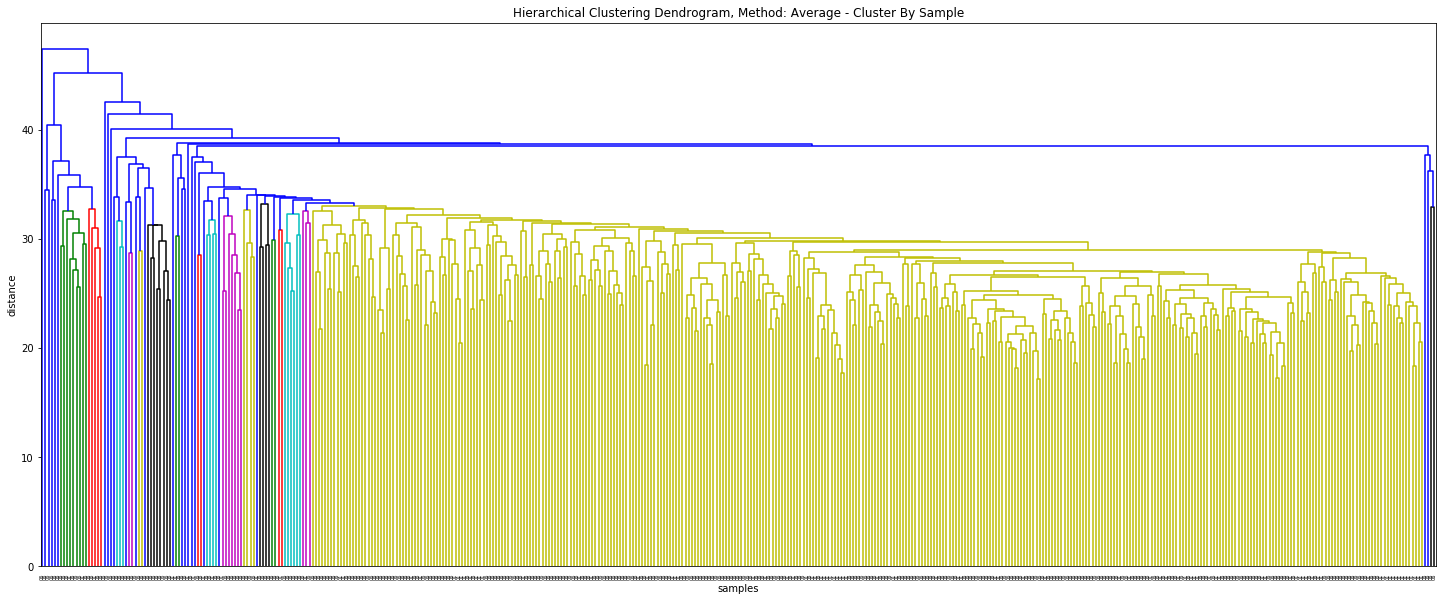


k = 2
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		21.65%		78.35%			448
2		metastasis (06)		0.0%		100.0%			1

k = 4
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		15.79%		84.21%			19
2		metastasis (06)		21.96%		78.04%			428
3		metastasis (06)		0.0%		100.0%			1
4		metastasis (06)		0.0%		100.0%			1

k = 10
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		0.0%		100.0%			2
2		metastasis (06)		17.65%		82.35%			17
3		metastasis (06)		0.0%		100.0%			19
4		metastasis (06)		40.0%		60.0%			5
5		metastasis (06)		22.69%		77.31%			401
6		primary (01)		100.0%		0.0%			1
7		metastasis (06)		0.0%		100.0%			1
8		metastasis (06)		0.0%		100.0%			1
9		metastasis (06)		0.0%		100.0%			1
10		metastasis (06)		0.0%		100.0%			1

k = 15
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		0.0%		100.0%			2
2		metastasis (06)		17.65%		82.35%			17
3		metastasis (06)		

In [40]:
### Clustering with 'average' method ### --> TERRIBLE!

# cluster and plot dendrogram with 'average' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'average')

# choose best k for 'average' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

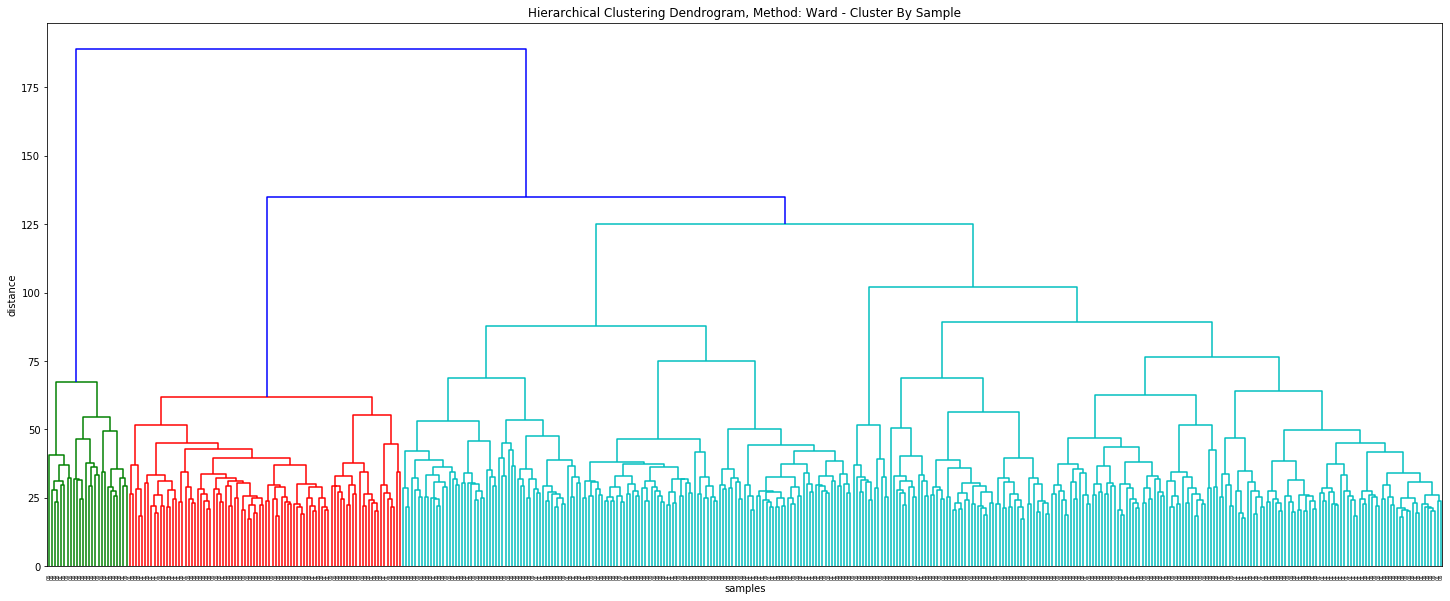


k = 2
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		11.54%		88.46%			26
2		metastasis (06)		22.22%		77.78%			423

k = 4
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		11.54%		88.46%			26
2		metastasis (06)		21.59%		78.41%			88
3		metastasis (06)		22.76%		77.24%			145
4		metastasis (06)		22.11%		77.89%			190

k = 10
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		11.54%		88.46%			26
2		metastasis (06)		21.59%		78.41%			88
3		metastasis (06)		9.68%		90.32%			31
4		metastasis (06)		18.52%		81.48%			27
5		metastasis (06)		20.45%		79.55%			44
6		metastasis (06)		37.21%		62.79%			43
7		metastasis (06)		0.0%		100.0%			12
8		metastasis (06)		5.77%		94.23%			52
9		metastasis (06)		9.26%		90.74%			54
10		metastasis (06)		47.22%		52.78%			72

k = 15
cluster		cluster_type		primary_cases	metastasis_cases	total_cases
1		metastasis (06)		12.5%		87.5%			8
2		metastasis (06)		11.11%		88

In [41]:
### Clustering with 'ward' method ### --> Not great, but less terrible!

# cluster and plot dendrogram with 'ward' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'ward')

# choose best k for 'ward' clustering:
for k in [2, 4, 10, 15, 25, 35, 45]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)
    

In [42]:
# select clustering method

# set chosen k based on previous analysis and chosen method
k = 45

# define clusters
clusters = fcluster(samples_link, k, criterion='maxclust')

In [43]:
cluster_types, primary_metastasis_cluster_list = define_cluster_types(a, k, samples_link, clusters)
primary_metastasis_clusters = np.asarray(primary_metastasis_cluster_list, dtype=np.int32)

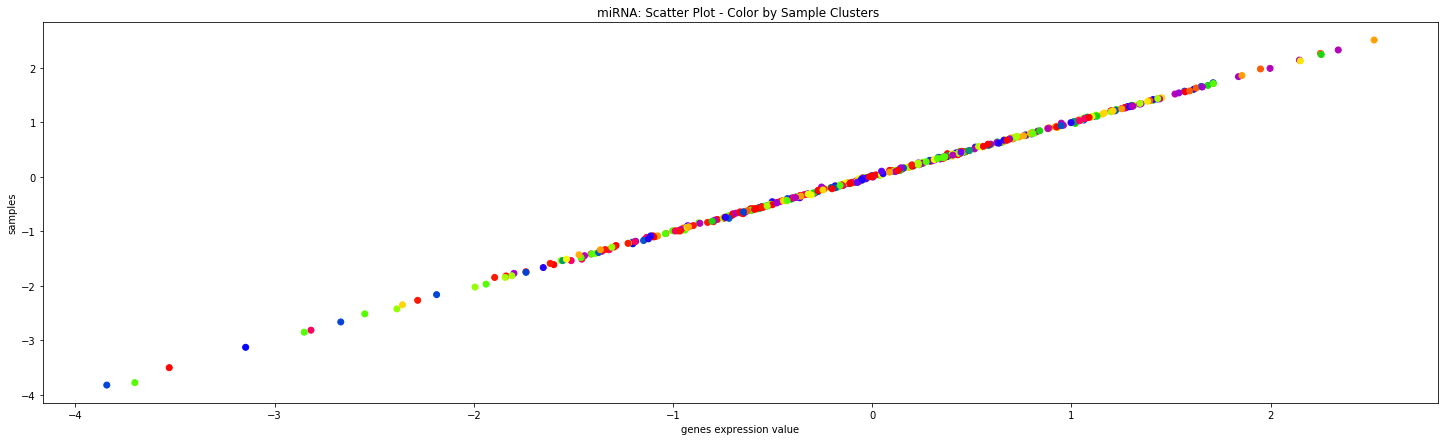

In [44]:
# 1. plot points with color by cluster
scatter_plot_samples(X, clusters, 'miRNA: Scatter Plot - Color by Sample Clusters ')

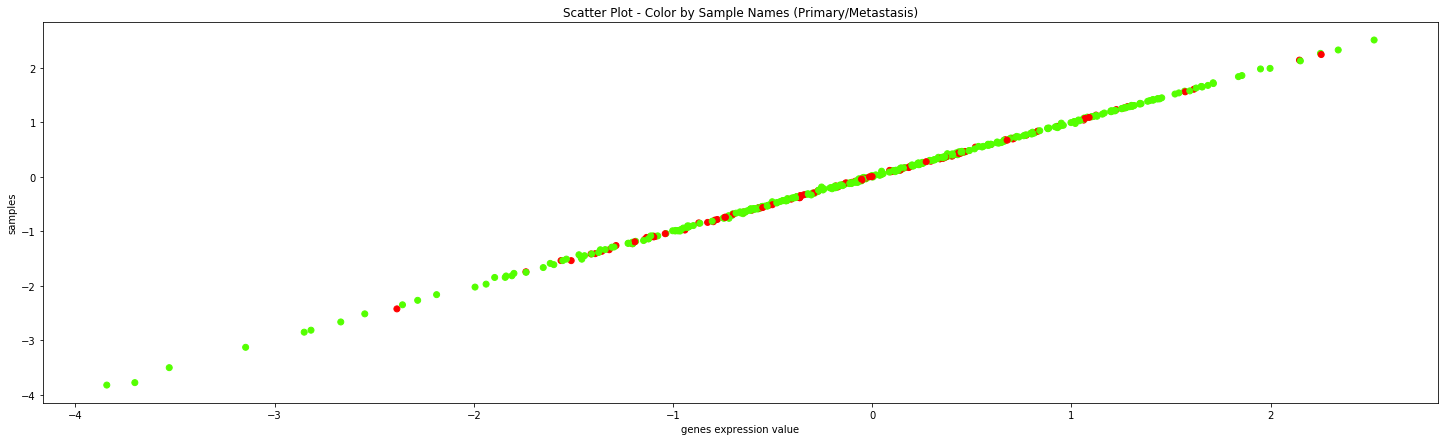

In [45]:
# 2. plot points with color by sample name (01 or 06) (actual tumor type: primary or metastasis)

color_values = np.asarray(samples_label_list, dtype=np.int32)
scatter_plot_samples(X, color_values, 'Scatter Plot - Color by Sample Names (Primary/Metastasis)')


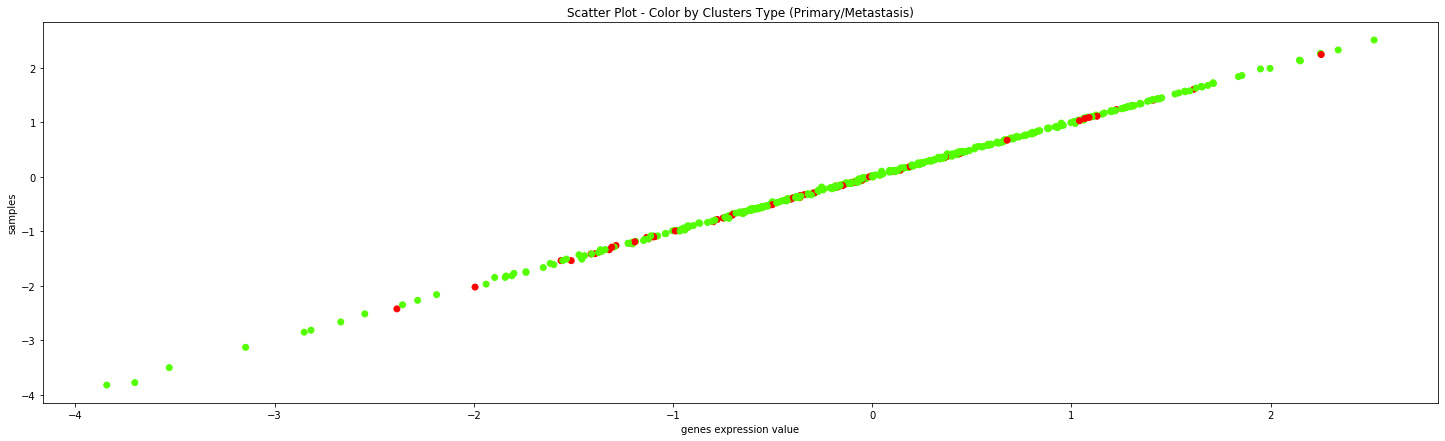

In [46]:
# 3. plot points with color by cluster tumor type (tumor typea as a result of clustering)
scatter_plot_samples(X, primary_metastasis_clusters, 'Scatter Plot - Color by Clusters Type (Primary/Metastasis)')

In [47]:
# Perform PCA in order to display data points on PCs

In [48]:
# normalize data to values between 0 and 1

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X)

print("data has been rescaled")
print("after rescaling: min={}, max={}".format(round(data_rescaled.min(), 2), round(data_rescaled.max(), 2)))

data has been rescaled
after rescaling: min=0.0, max=1.0


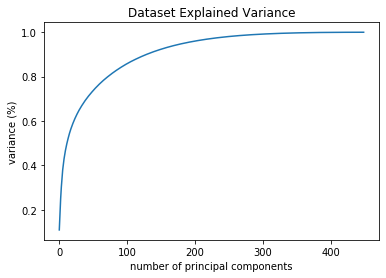

based on graph: selecting 200 principal components that appear to account for close to 100% of the variance


In [49]:
# Select number of principal components to use for PCA
    
plot_explained_variance(data_rescaled)

# based on this graph we need to decide how many principal components to use
# we will not select the maximum possible, in order to preserve only principal components
# however, we want to select a number of components where the graph slope is not very big

# we will decide to use 200 principal components

print("based on graph: selecting 200 principal components that appear to account for close to 100% of the variance")

In [50]:
# perform PCA with 300 components

components = 200

print("plotting the explained variance per principal component")
dataset = perform_pca_and_plot_explained_variance(X, data_rescaled, components)

# based on the graph, we can see that: 
# PC1 + PC2 are responsible for nearly 18% of the explained variance
# PC1 + PC2 + PC3 are responsible for nearly 25% of the explained variance
# we will use these 3 PCs to graph the points on these axis

plotting the explained variance per principal component


In [51]:
# PC1 + PC2 are responsible for 21% of the explained variance

In [52]:
add_cluster_info_to_dataset(a, clusters, cluster_types)

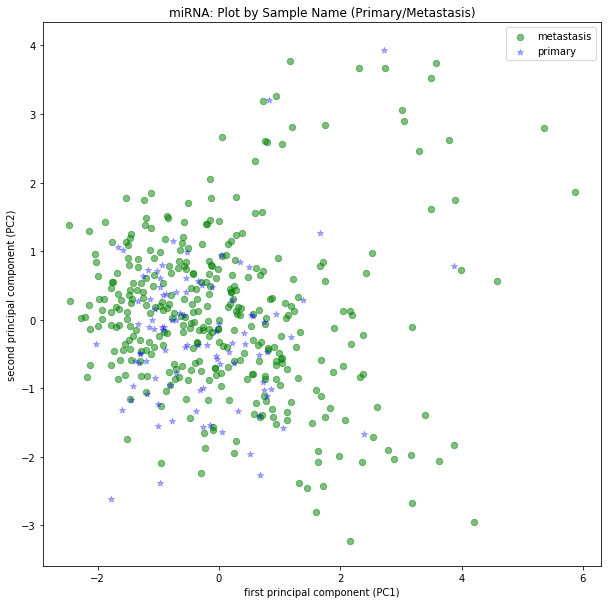

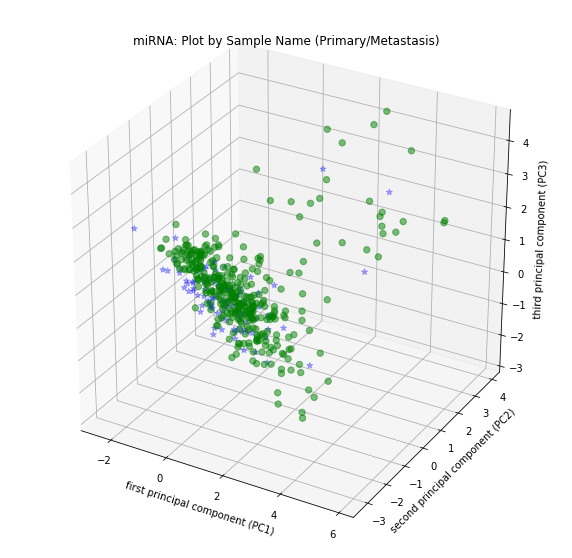

In [53]:
## 2D plot on PC1, PC2 by sample name (primary = 01, metastasis = 06) ##

marker = {'primary':'*','metastasis':'o'}
alpha = {'primary':.3, 'metastasis':.5}

plot_2D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastasis':'green'}, 
        {'primary':'primary','metastasis':'metastasis'},
        "miRNA: Plot by Sample Name (Primary/Metastasis)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 by sample name (primary = 01, metastasis = 06) ##

plot_3D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastasis':'green'},
        {'primary':'primary','metastasis':'metastasis'},
        "miRNA: Plot by Sample Name (Primary/Metastasis)",
        marker,
        alpha,)

# resulting picture is really similar to gene expression picture!

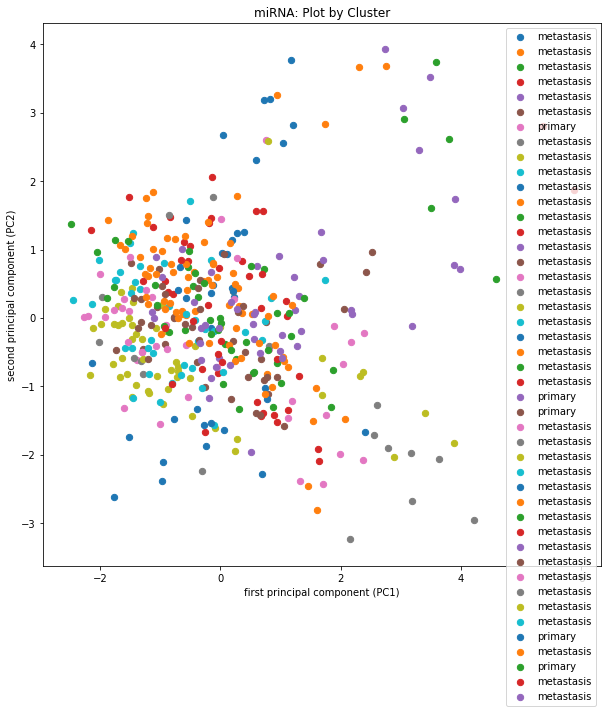

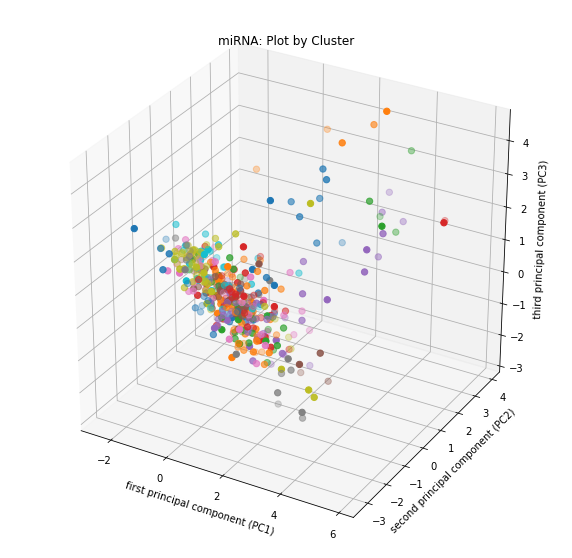

In [54]:
# specify labels
labl_dict = {}
for x in range(1, k+1):
    labl_dict[x] = cluster_types[x-1][1]


## 2D plot on PC1, PC2 by clustering results ##

plot_2D(dataset, a.cluster, a.cluster, labl_dict, "miRNA: Plot by Cluster")

## 3D plot on PC1, PC2, PC3 by clustering results ##

plot_3D(dataset, a.cluster, a.cluster, labl_dict, "miRNA: Plot by Cluster")


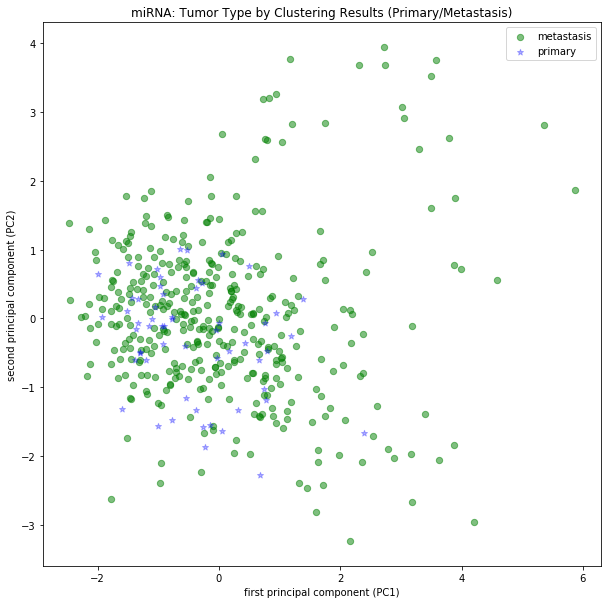

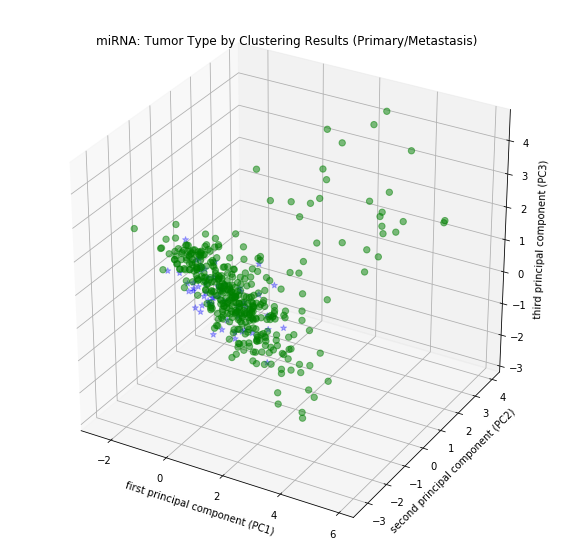

In [55]:
# specify labels

marker = {'primary':'*','metastasis':'o', 'unknown':'.'}
alpha = {'primary':.3, 'metastasis':.5, 'unknown':.2}

## 2D plot on PC1, PC2 tumor type by clustering results ##

plot_2D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastasis':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastasis':'metastasis', 'unknown':'unknown'}, 
        "miRNA: Tumor Type by Clustering Results (Primary/Metastasis)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 tumor type by clustering results ##
plot_3D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastasis':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastasis':'metastasis', 'unknown':'unknown'}, 
        "miRNA: Tumor Type by Clustering Results (Primary/Metastasis)",
        marker,
        alpha,)

Research Questions and Analysis Methodology:

<u>Question # 4</u>

**Q: Which genes have a higher expression in tumors vs healthy skin? Are these genes similar to genes more highly expressed in primary tumors vs metastases?**

**How do we define a highly-expressed gene:**

- Per gene per dataset, we have a gene expression value per sample, but want to define a single gene expression value to use to represent that gene (so that we can compare all values and find large ones to be highly expressed)
- We considered 2 options for this definition:
    - Option 1: Using **mean gene expression** per gene --> <u>Not a good option</u>
        - Explanation: 
            - We are using datasets that we normalized
            - Therefore, means for all genes should be zero if we look at the <u>entire dataset</u> (for example, gtex data or gene expression data)
            - If we look at subsets of the dataset (for example, 01 only or 06 only for gene expression) it would be ok
    - Option 2: Using **median gene expression** per gene --> <u>OK option</u>
        - The normalization affects the values, but means per gene can have a range of values
        - We arbitrarily selected to look at genes with median values in the 99.9th percentile, but defined this as a parameter, and other values can also be examined
        
    
***Analysis Description:*** 

- Finding most highly expressed genes in primary vs metastases samples:
    - We divided the gene expression dataset into a primary tumor dataset (01 samples) and a metastases dataset (06 samples)
    - We calculated the median value per gene (according to all relevant samples)
    - We graphed the median gene expression by sample type (primary/metastasis) to help select a cutoff line
    - We defined a cutoff line at gene expressian medians in the  99.9 percentile (this percentile was arbitrarily selected, based on graphing, but it is a parameter that can be changed in the analysis)
    - We created a dataset for 01 samples and 06 samples that contains only genes with median values equal or greater than the 99.9th percentile value, and combined these results into one single dataset (highly_expressed_01_vs_06)
    
- compare to healthy skin to tumor sample 
    - We had to match ensemble_ids in the gtex_data dataset, that contains healthy people sking samples, to 'genes' in the gene_data dataset
        1. We researched the various types of gene IDs that exist, in order to understand which IDs we are actually looking at and need to translate between, because there are numerous gene id versions. According to our research:
            - our gtex dataset uses enemble_ids, also refered to as: "gene stable id"
            - our gene expression dataset uses a combination of "gene name" and "NCBI gene id", separated by a period 
        2. We searched for methods for converting between these genes ids, and found several options:
            - packages available only in R
            - an online conversion interface, http://www.ensembl.org/biomart/martview/
            - an online conversion interface, https://mygene.info/demo (we used it, but it had many missing translations)
        3. Eventually we managed to convert the most IDs using http://www.ensembl.org/biomart/martview/, so we selected that method, with the following parameters:
            - FILTERS:  
                - GENE: Input external references ID list [Max 500 advised]: "Gene stable ID(s) 

            - ATTRIBUTES:
                - GENE: Ensembl: "Gene stable ID", "Gene name"
                - EXTERNAL: External References: NCBI Gene ID
        4. Dealing with interface limitations: the interface can translate a maximum of 500 gene IDs at a time, therefore we divided the ensemble_ids in gtex_data into sub-datasets of 500 ids or less
            - gtex_data contains 16593 ensemble_ids, so the dataset had to be divided int 34 datasets
            - each file was uploaded to the interface, and the results were saved in 34 text files called "mart_export (#).txt" 
            - the 34 result text files were combined into a single conversions dataset
            - a gene column was added to the conversions dataset, created using: "gene name"."NCBI gene id" where "NCBI gene id" was available, and "gene name" only where it was not available.
        5. The new conversions 'gene' column was merged into the gtex_data dataset
        6. Gtex_data was merged with the 'gene' column of gene_data, to examine the genes that could be matched
            - it is important to note that gene_data contains only genes that have high variance, because we removed all genes that had low variance values as part of the normalization and data cleaning process
        7. Only matched genes (a total of 5181 genes) were left in the gtex dataset
    - We could not directly compare gene expression values in gene_data to the numbers in the gtex_data dataset, even for matching genes, because according to our research, the numbers are obtained through different processes before they are normalized
    - Per dataset (gtex_data, gene_data (all samples, 01 and 06 combined)) we calculated the median value per gene according to all relevant samples
    - We defined a cutoff line at medians in the  99.9 percentile
    - We created a dataset for gtex samples and tumor samples that contains only genes with median values equal or greater than the 99.9th percentile value, and combined these results into one single dataset (highly_expressed_gtex_vs_cancer)
    
- We created a combined dataset for highly-expressed genes in all datasets: highly_expressed_comparison (by combining highly_expressed_gtex_vs_cancer and highly_expressed_01_vs_06), and also graphed the dataset. 

**A: By looking at the results,** 

**- We see that out of 11 genes that have a high expression in tumors, 7 (64%) are also highly expressed in metastases. These genes are: CSAG1.158511, MAGEA12.4111, MAGEA3.4102, MAGEA2.4101, CSAG3.389903, MAGEA6.4105, RPS28.6234**

**- We see that out of 5 highly expressed genes in healthy skin, 1 gene (20%) is also highly expressed in metastases: RPS4Y1.6192**



In [58]:
# divide dataframes['gene_data'] into a dataset for primary samples (df_01) and for metastases samples (df_06)

# create dataset for primary samples (df_01)
df_01 = pd.concat([dataframes['gene_data']['gene'], 
                dataframes['gene_data'].filter(regex='.01',axis=1)], 
                axis=1, 
               sort=False)

# create dataset for metastases samples (df_06)
df_06 = pd.concat([dataframes['gene_data']['gene'], 
                dataframes['gene_data'].filter(regex='.06',axis=1)], 
                axis=1, 
               sort=False)


In [59]:
# pass 'mean' or 'median' as mean_or_median
def plot_highly_expressed_genes(data, mean_or_median, title_additions):           
    plt.figure(figsize=(10, 10))
    plt.title('{} gene expression {}'.format(mean_or_median, title_additions))
    sns.barplot(x = data['gene'], y = data['{}_exp'.format(mean_or_median)])
    plt.xlabel("highly expressed genes {}".format(title_additions))
    plt.xticks(rotation=90)
    plt.ylabel("{} gene expression value after normalizing".format(mean_or_median))

def find_highly_expressed_medians(data, quantile, title_additions):
    # creade a dataset of gene name, median gene expression per gene based on given data
    medians = pd.concat([data['gene'], data.iloc[:, 1:].median(axis=1)], axis=1, sort=False)
    medians.columns = ['gene', 'median_exp']
    
    # sort new dataset by mean gene expression (high to low), this is used for making a pretty graph
    medians = medians.sort_values(by = 'median_exp', ascending=False)
    
    # we want to define the top quantile-th percentile of values
    medians_limit = round(medians['median_exp'].quantile(quantile), 2)
    print("medians ", quantile*100, "-th percentile value: ", medians_limit)

    # keep only values greater or equal to limit
    highly_expressed_medians = medians[medians['median_exp'] >= medians_limit]
    
    # graph results
    plot_highly_expressed_genes(highly_expressed_medians, 'median', title_additions)
    
    highly_expressed_medians.columns = ['gene', 'median_exp']
    return medians, highly_expressed_medians

###############################################################################
# The following functions are separate in order to enable individual analysis!#
###############################################################################

# name examples: 01, 06 --> this will be added to column names
#def combine_means_and_medians(highly_expressed_means, highly_expressed_medians, name):
#    highly_expressed = pd.merge(highly_expressed_means[['gene', 'mean_exp']], highly_expressed_medians[['gene', 'median_exp']], on='gene', how='outer')
#    highly_expressed.columns = ['gene', 'mean_exp_{}'.format(name), 'median_exp_{}'.format(name)]
#    return highly_expressed


def combine_highly_expressed_datasets(highly_expressed_data_1, highly_expressed_data_2, name_data_1, name_data_2):
    if name_data_1 is not None and name_data_2 is not None:
        highly_expressed_data_1.columns = ['gene', 'median_exp_{}'.format(name_data_1)]
        highly_expressed_data_2.columns = ['gene', 'median_exp_{}'.format(name_data_2)]
    return pd.merge(highly_expressed_data_1, highly_expressed_data_2, on='gene', how='outer')

###################################################
# The following function takes a long time to run #
###################################################
# pass 'mean' or 'median' as mean_or_median

def plot_mean_or_median_gene_expression(mean_or_median, data, ylabel_additions):
    #plotting means of genes exp (this is a subset of data we previously normalized)
    plt.figure(figsize=(10, 10))
    plt.title("{} gene expression by gene".format(mean_or_median))
    sns.barplot(x = data['gene'], y = data['{}_exp'.format(mean_or_median)]) #this takes a long time
    plt.xlabel("gene")
    plt.ylabel("{} gene expression value {}".format(mean_or_median, ylabel_additions))

Highly Expressed Genes: Primary Tumor
medians  99.9 -th percentile value:  1.16


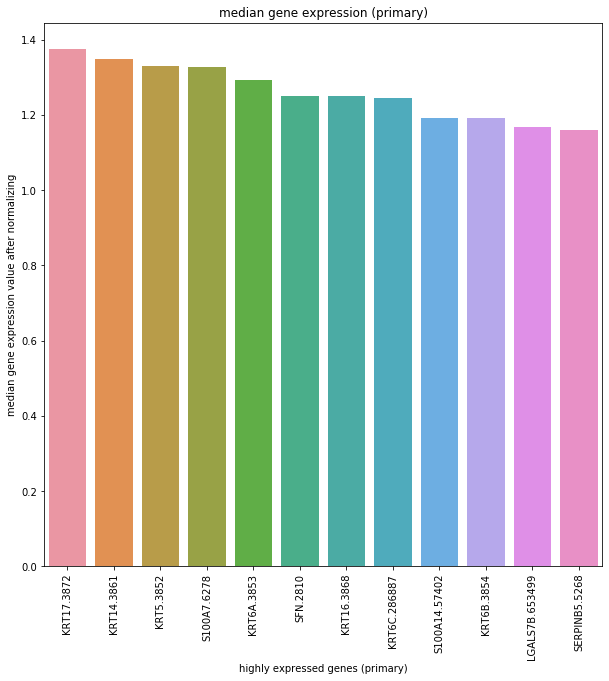

In [60]:
print("Highly Expressed Genes: Primary Tumor")

df_01, highly_expressed_medians_01 = find_highly_expressed_medians(df_01, 0.999, "(primary)")


In [61]:
### This takes a long time to run! ###
# graph gene expression medians (primary)

#print("graphing overall gene expression medians (primary)")

#plot_mean_or_median_gene_expression('median', df_01, "(primary)")

Highly Expressed Genes: Metastasis
medians  99.9 -th percentile value:  0.41


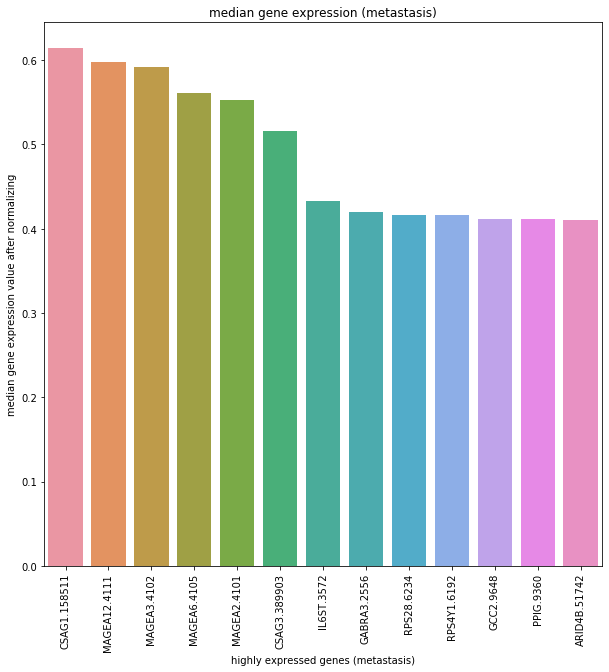

In [62]:
print("Highly Expressed Genes: Metastasis")
df_06, highly_expressed_medians_06 = find_highly_expressed_medians(df_06, 0.999, "(metastasis)")

In [63]:
### This takes a long time to run! ###
#graph gene expression medians (primary)

#print("graphing overall gene expression medians (metastasis)")

#plot_mean_or_median_gene_expression('median', df_06, "(metastasis)")

In [64]:
highly_expressed_01_vs_06 = combine_highly_expressed_datasets(
                                                        highly_expressed_medians_01, 
                                                        highly_expressed_medians_06, 
                                                        '01', 
                                                        '06')

highly_expressed_01_vs_06

gene  median_exp_01  median_exp_06
0       KRT17.3872       1.376228            NaN
1       KRT14.3861       1.348173            NaN
2        KRT5.3852       1.329086            NaN
3      S100A7.6278       1.326628            NaN
4       KRT6A.3853       1.293599            NaN
5         SFN.2810       1.251768            NaN
6       KRT16.3868       1.249222            NaN
7     KRT6C.286887       1.246476            NaN
8    S100A14.57402       1.192479            NaN
9       KRT6B.3854       1.192000            NaN
10  LGALS7B.653499       1.166912            NaN
11   SERPINB5.5268       1.160886            NaN
12    CSAG1.158511            NaN       0.614003
13    MAGEA12.4111            NaN       0.597770
14     MAGEA3.4102            NaN       0.591515
15     MAGEA6.4105            NaN       0.561095
16     MAGEA2.4101            NaN       0.552307
17    CSAG3.389903            NaN       0.515523
18      IL6ST.3572            NaN       0.432725
19     GABRA3.2556            NaN       0.419922
20      RPS28.6234            NaN       0.416435
21     RPS4Y1.6192            NaN       0.416429
22       GCC2.9648            NaN       0.411727
23       PPIG.9360            NaN       0.411701
24    ARID4B.51742            NaN       0.410166

In [65]:
# remove quotations from ensemble_id

def remove_quotations(row):
    row.ensemble_id = row.ensemble_id.strip('"')
    return row

dataframes['gtex_data'] = dataframes['gtex_data'].apply(remove_quotations, axis = 'columns')

In [66]:
# divide gtex_data's ensemble ids into sections of 500 genes or less, so we need 34 datasets of 500 genes
ensemble_dfs = {}

data = dataframes['gtex_data']['ensemble_id']
for x in range(34):
    df = pd.DataFrame()
    df = data[:500]
    ensemble_dfs[x] = df
    data = data[500:]

# export values to CSV
for x in range(34):
    ensemble_dfs[x].to_csv('{}.csv'.format(x), index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



enter http://www.ensembl.org/biomart/martview/

FILTERS:  
- GENE: Input external references ID list [Max 500 advised]: "Gene stable ID(s) 

ATTRIBUTES:
- GENE: Ensembl: "Gene stable ID", "Gene name"
- EXTERNAL: External References: NCBI Gene ID

Results were saved in 34 text files called "mart_export (#).txt"

In [67]:
# importing results and combining them into one df

names = ['ensemble_id' , 'Gene name', 'NCBI gene ID']
conversions = pd.read_csv('mart_export (0).txt', names=names, skiprows=1, sep=",")

for x in range(1, 34):
    df = pd.read_csv('mart_export ({}).txt'.format(x), names=names, skiprows=1, sep=",")
    conversions = pd.concat([conversions, df], axis=0, sort=False).reset_index(drop=True)


print("shape: ", conversions.shape)
display(conversions.head())

shape:  (16093, 3)


ensemble_id Gene name  NCBI gene ID
0  ENSG00000000938       FGR        2268.0
1  ENSG00000001460     STPG1       90529.0
2  ENSG00000001461    NIPAL3       57185.0
3  ENSG00000004455       AK2         204.0
4  ENSG00000004487     KDM1A       23028.0

In [68]:
import math

def create_gene_name(row):
    ncbi_gene_id = float(row['NCBI gene ID'])
    if not math.isnan(ncbi_gene_id):
        ncbi_gene_id = str(int(ncbi_gene_id))
        row.gene = row['Gene name'] + "." + ncbi_gene_id
    else:
        row.gene = row['Gene name']
    return row

# in order for apply to work, the column ['gene'] should already exist in dataframe
conversions['gene'] = np.nan

# update conversions to include a row of "Gene name"."NCBI gene ID", they both exist
conversions = conversions.apply(create_gene_name, axis = 'columns')

In [69]:
dataframes['gtex_data'] = pd.merge(
            dataframes['gtex_data'], 
            conversions[['ensemble_id', 'gene']], 
            on='ensemble_id', 
            how='left')


In [72]:
# trying to match rows from dataframes['gene_data']
dataframes['gene_data']['gene2'] = dataframes['gene_data']['gene']

m = pd.merge(
        dataframes['gtex_data'], 
        dataframes['gene_data'][['gene', 'gene2']], 
        on='gene', 
        how='inner')


In [75]:
# We managed to match only 5181 genes (this is not terrible, taking into account gene expression data removed many genes)
# we'll preform the analysis with only matched genes

In [76]:
# comparing only matched genes
dataframes['gtex_data'] = m
dataframes['gtex_data'].head()
dataframes['gtex_data'] = dataframes['gtex_data'].drop(columns=['ensemble_id', 'gene2'])

In [78]:
# reorder columns for gtex_data
cols = list(dataframes['gtex_data'].columns)
cols = [cols[-1]] + [x for x in cols[:-1]]
dataframes['gtex_data']  = dataframes['gtex_data'][cols]

In [79]:
dataframes['gtex_data'].head()

gene  GTEX-111YS-0006-SM-5NQBE  GTEX-1122O-0005-SM-5O99J  \
0  KLHL17.339451                 -0.279908                 -0.835156   
1  PLEKHN1.84069                 -0.200912                 -1.013192   
2     HES4.57801                  0.227358                  2.186521   
3     ISG15.9636                  0.193308                  1.331465   
4    AGRN.375790                 -0.274640                  1.210520   

   GTEX-1128S-0005-SM-5P9HI  GTEX-113IC-0006-SM-5NQ9C  \
0                 -0.408072                 -1.410811   
1                  0.641047                  1.477039   
2                 -0.430179                  2.149775   
3                 -1.224713                  2.529799   
4                  0.141486                  3.308054   

   GTEX-113JC-0006-SM-5O997  GTEX-117XS-0005-SM-5PNU6  \
0                  0.523505                 -0.521197   
1                  0.372336                 -1.923460   
2                  1.411524                 -1.272982   
3                  3.673485                 -0.275449   
4                  4.207091                 -0.848101   

   GTEX-117YW-0005-SM-5NQ8Z  GTEX-1192W-0005-SM-5NQBQ  \
0                  0.053786                 -0.106698   
1                 -0.756503                 -1.661922   
2                 -0.855489                  0.464439   
3                 -0.389703                  0.486343   
4                  0.224843                  0.175697   

   GTEX-11DXW-0006-SM-5NQ7Y  ...  GTEX-ZVE2-0006-SM-51MRW  \
0                 -0.260480  ...                 2.496293   
1                 -2.192522  ...                 1.438572   
2                  0.101561  ...                 0.641636   
3                 -0.203910  ...                -0.448540   
4                 -0.658319  ...                -0.077691   

   GTEX-ZVP2-0005-SM-51MRK  GTEX-ZVT2-0005-SM-57WBW  GTEX-ZVT3-0006-SM-51MT9  \
0                -0.158198                 0.327074                -1.277016   
1                -0.931609                -2.508796                -1.060247   
2                 1.522860                 0.658801                 0.245804   
3                -2.588012                 0.469086                 0.305854   
4                -1.306012                 1.015157                -0.983269   

   GTEX-ZVT4-0006-SM-57WB8  GTEX-ZVTK-0006-SM-57WBK  GTEX-ZVZP-0006-SM-51MSW  \
0                -0.452272                 0.132588                -0.647277   
1                 2.616110                 0.229421                 0.735088   
2                -0.213726                -0.422631                -0.968229   
3                 0.892913                -0.720614                 0.052023   
4                -0.732651                -0.796740                -0.016115   

   GTEX-ZVZQ-0006-SM-51MR8  GTEX-ZXES-0005-SM-57WCB  GTEX-ZXG5-0005-SM-57WCN  
0                -1.332039                -1.091149                 0.791253  
1                -0.182378                -0.584952                 1.269399  
2                -0.134881                -1.354220                -0.103158  
3                -0.798169                 0.626281                -1.101371  
4                -0.402000                 1.133667                -1.043875  

[5 rows x 394 columns]

Highly Expressed Genes: GTEX 
medians  99.9 -th percentile value:  0.5


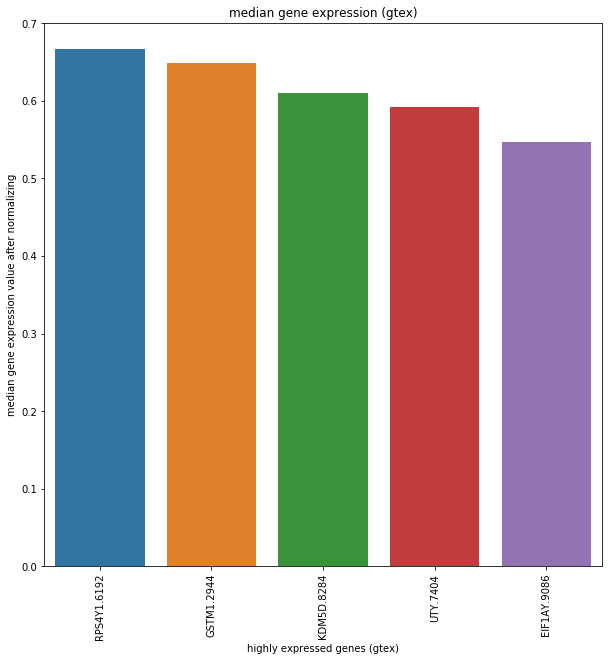

In [80]:
print("Highly Expressed Genes: GTEX ")
df_gtex, highly_expressed_medians_gtex = find_highly_expressed_medians(dataframes['gtex_data'], 0.999, "(gtex)")

Highly Expressed Genes: Tumors(primary/metastasis) 
medians  99.9 -th percentile value:  0.37


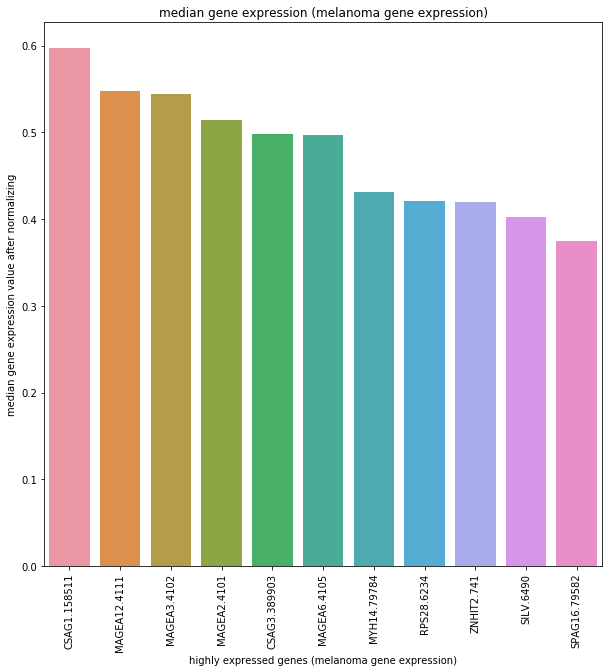

In [81]:
print("Highly Expressed Genes: Tumors(primary/metastasis) ")
df_cancer, highly_expressed_medians_cancer = find_highly_expressed_medians(dataframes['gene_data'], 0.999, "(melanoma gene expression)")

In [82]:
highly_expressed_gtex_vs_cancer = combine_highly_expressed_datasets(
                                                        highly_expressed_medians_gtex, 
                                                        highly_expressed_medians_cancer, 
                                                        'gtex', 
                                                        'tumor')

highly_expressed_gtex_vs_cancer

gene  median_exp_gtex  median_exp_tumor
0    RPS4Y1.6192         0.667302               NaN
1     GSTM1.2944         0.649312               NaN
2     KDM5D.8284         0.610324               NaN
3       UTY.7404         0.592438               NaN
4    EIF1AY.9086         0.547142               NaN
5   CSAG1.158511              NaN          0.596801
6   MAGEA12.4111              NaN          0.547988
7    MAGEA3.4102              NaN          0.544647
8    MAGEA2.4101              NaN          0.514051
9   CSAG3.389903              NaN          0.497883
10   MAGEA6.4105              NaN          0.496738
11   MYH14.79784              NaN          0.430708
12    RPS28.6234              NaN          0.420327
13    ZNHIT2.741              NaN          0.420014
14     SILV.6490              NaN          0.402322
15  SPAG16.79582              NaN          0.374652

In [87]:
# compare highly_expressed_gtex_vs_cancer with highly_expressed_01_vs_06

highly_expressed_comparison = combine_highly_expressed_datasets(
                                                        highly_expressed_gtex_vs_cancer, 
                                                        highly_expressed_01_vs_06, 
                                                        None, 
                                                        None)

# highly_expressed_comparison = highly_expressed_comparison.fillna(0)

print("Compare Highly Expressed Genes for: gtex data, tumor data, only primary tumor data (01), only metastasis (06)\n")
print("A gene is considered highly expressed if the median of its samples is in the 99.9th percentile of values in that dataset")
highly_expressed_comparison

Compare Highly Expressed Genes for: gtex data, tumor data, only primary tumor data (01), only metastasis (06)

A gene is considered highly expressed if the median of its samples is in the 99.9th percentile of values in that dataset


gene  median_exp_gtex  median_exp_tumor  median_exp_01  \
0      RPS4Y1.6192         0.667302               NaN            NaN   
1       GSTM1.2944         0.649312               NaN            NaN   
2       KDM5D.8284         0.610324               NaN            NaN   
3         UTY.7404         0.592438               NaN            NaN   
4      EIF1AY.9086         0.547142               NaN            NaN   
5     CSAG1.158511              NaN          0.596801            NaN   
6     MAGEA12.4111              NaN          0.547988            NaN   
7      MAGEA3.4102              NaN          0.544647            NaN   
8      MAGEA2.4101              NaN          0.514051            NaN   
9     CSAG3.389903              NaN          0.497883            NaN   
10     MAGEA6.4105              NaN          0.496738            NaN   
11     MYH14.79784              NaN          0.430708            NaN   
12      RPS28.6234              NaN          0.420327            NaN   
13      ZNHIT2.741              NaN          0.420014            NaN   
14       SILV.6490              NaN          0.402322            NaN   
15    SPAG16.79582              NaN          0.374652            NaN   
16      KRT17.3872              NaN               NaN       1.376228   
17      KRT14.3861              NaN               NaN       1.348173   
18       KRT5.3852              NaN               NaN       1.329086   
19     S100A7.6278              NaN               NaN       1.326628   
20      KRT6A.3853              NaN               NaN       1.293599   
21        SFN.2810              NaN               NaN       1.251768   
22      KRT16.3868              NaN               NaN       1.249222   
23    KRT6C.286887              NaN               NaN       1.246476   
24   S100A14.57402              NaN               NaN       1.192479   
25      KRT6B.3854              NaN               NaN       1.192000   
26  LGALS7B.653499              NaN               NaN       1.166912   
27   SERPINB5.5268              NaN               NaN       1.160886   
28      IL6ST.3572              NaN               NaN            NaN   
29     GABRA3.2556              NaN               NaN            NaN   
30       GCC2.9648              NaN               NaN            NaN   
31       PPIG.9360              NaN               NaN            NaN   
32    ARID4B.51742              NaN               NaN            NaN   

    median_exp_06  
0        0.416429  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5        0.614003  
6        0.597770  
7        0.591515  
8        0.552307  
9        0.515523  
10       0.561095  
11            NaN  
12       0.416435  
13            NaN  
14            NaN  
15            NaN  
16            NaN  
17            NaN  
18            NaN  
19            NaN  
20            NaN  
21            NaN  
22            NaN  
23            NaN  
24            NaN  
25            NaN  
26            NaN  
27            NaN  
28       0.432725  
29       0.419922  
30       0.411727  
31       0.411701  
32       0.410166

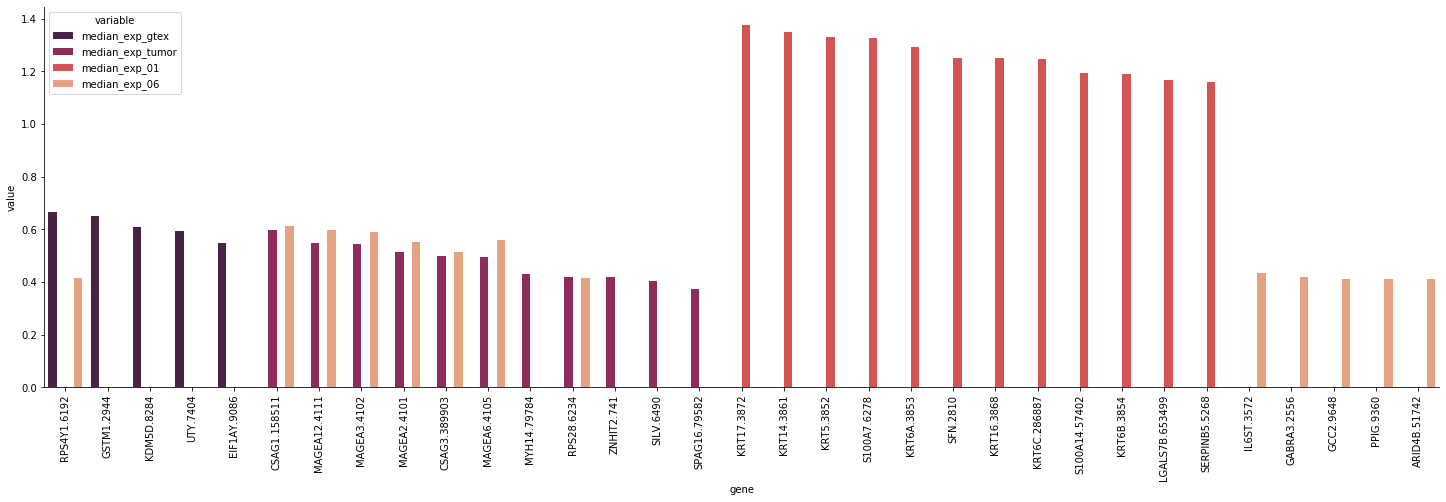

In [88]:
# create a categorical graph of the results

fig, ax1 = plt.subplots(figsize=(25, 7))
tidy = pd.melt(highly_expressed_comparison, id_vars=['gene'])
sns.barplot(x='gene', y='value', hue='variable', data=tidy, ax=ax1, palette="rocket")
sns.despine(fig)
plt.xticks( rotation=90)
plt.show()


In [222]:
def separate_and_transpose(base_df, name, column_name):
    for group in ['01', '06']:
        #filter dataframe for only primary tumor or only metastasis
        regex = '.{}$|{}'.format(group, column_name) #example: regex='.06$|gene' and regex='.01$|gene'
        dataset_name = '{}_{}'.format(name, group)
        df = base_df.filter(regex=regex,axis=1)
        # transpose dataframe 
        df = df.T # transpose
        df.columns = df.iloc[0, :] # use first row as column names
        df = df.iloc[1:, :]
        dataframes[dataset_name] = df
        
# create dataframes['gene_data_01'], dataframes['gene_data_06']:
separate_and_transpose(dataframes['gene_data'], 'gene_data', 'gene')

# create dataframes['micro_rna_data_01'], dataframes['micro_rna_data_06']:
separate_and_transpose(dataframes['micro_rna_data'], 'micro_rna_data', 'micro_rna')

In [193]:
# df_01, df_06 description: rows == people, columns == genes
#n: the number of genes/mirnas with the biggest difference in medians
def find_differences(df_01, df_06, n):
    # if the dataset contains nulls, replace null cells with 0 values
    df_01 = df_01.fillna(0)
    df_06 = df_06.fillna(0)
    # create mini-datasets that contain the median value for each column
    a = df_01.describe() # a contains median expression for each gene for primary tumor cases (01)
    b = df_06.describe() # b contains median expression for each gene for metastasis cases (06)
    # keep only medians!
    aa = a.loc[a.index == '50%']
    bb = b.loc[b.index == '50%']
    # rename columns for clairty
    aa = aa.rename(index={'50%': '01_median'})
    bb = bb.rename(index={'50%': '06_median'})
    # combine a and b into a new dataset
    median_dataset = pd.concat([aa, bb], axis=0, sort=False).T
    # add abs_difference column to new dataset (this column defines the "distance" between 01 and 06 medians)
    median_dataset['abs_difference'] = abs(median_dataset['01_median'] - median_dataset['06_median'])
    # sort median_dataset by 'abs_difference' (from max difference to min)
    median_dataset = median_dataset.sort_values(by='abs_difference', ascending = False)
    # keep top n rows
    median_dataset = median_dataset.iloc[:n, :]
    # (returning a, b for future calculations)
    return median_dataset, a, b

# get 50 results for gene data:
dataframes['gene_data_medians'], gene_01_description, gene_06_description = find_differences(dataframes['gene_data_01'], dataframes['gene_data_06'], 50)
# get 50 results for mirna data:
dataframes['micro_rna_data_medians'], mirna_01_description, mirna_06_description = find_differences(dataframes['micro_rna_data_01'], dataframes['micro_rna_data_06'], 50)

success1
success2


In [197]:
# create list of genes, mirnas found:
genes_found = list(dataframes['gene_data_medians'].index)
mirna_found = list(dataframes['micro_rna_data_medians'].index)

def minimize_dataset(selected_columns, df_01, df_06):
    df_01 = df_01[selected_columns]
    df_06 = df_06[selected_columns]
    return df_01, df_06
    
genes_found_data_01, genes_found_data_06 = minimize_dataset(genes_found, dataframes['gene_data_01'], dataframes['gene_data_06'])
mirna_found_data_01, mirna_found_data_06 = minimize_dataset(mirna_found, dataframes['micro_rna_data_01'], dataframes['micro_rna_data_06'])

In [207]:
# calculate min and max values for y axis

def create_axis_values(datasets):
    axis_values = {}
    for dataset, num in datasets:
        min_val = dataset.iloc[3, :].min().item()
        max_val = dataset.iloc[-1, :].max().item()
        if "min_val" not in axis_values or min_val < axis_values["min_val"]:
            axis_values["min_val"] = min_val
        if "max_val" not in axis_values or max_val > axis_values["min_val"]:
            axis_values["max_val"] = max_val
    return axis_values

gene_axis = create_axis_values([(gene_01_description, '01'), (gene_06_description, '06')])
mirna_axis = create_axis_values([(mirna_01_description, '01'), (mirna_06_description, '06')])

In [209]:
# graph genes or mirna to see comparison:

# select x (number between 1-49, refering to column order in dataset, to view relevant graph)
# select relevant 01, 06 datasets
# select relevant median_df
# select gene_axis / mirna_axis
def graph(x, df_found_01, df_found_06, median_df, axis_params):
    # create dataset for x only (remove rows where x is zero: dropna that doesn't affect other genes)
    df_01 = df_found_01[df_found_01.iloc[:, x] != 0]
    df_06 = df_found_06[df_found_06.iloc[:, x] != 0]

    data_type_name = df_01.columns[x]
    data_median_01 = median_df.loc[median_df.index == data_type_name]['01_median'].item()
    data_median_06 = median_df.loc[median_df.index == data_type_name]['06_median'].item()

    y = range(int(axis_params["min_val"]-10) , int(axis_params["max_val"]+10))
    fig = plt.figure(figsize=(14,7))
    ax = plt.subplot(1, 1, 1)
    ax.scatter(df_01.index, df_01.iloc[:, x], label="{}_01".format(df_01.columns[x]))
    ax.scatter(df_06.index, df_06.iloc[:, x], label="{}_06".format(df_06.columns[x]))

    horiz_line_01 = np.array([data_median_01 for i in range(len(list(df_01.index)))])
    ax.plot(df_01.index, horiz_line_01, 'r--') 

    horiz_line_06 = np.array([data_median_06 for i in range(len(list(df_06.index)))])
    ax.plot(df_06.index, horiz_line_06, 'r-') 

    plt.legend(loc='upper left');
    plt.show()

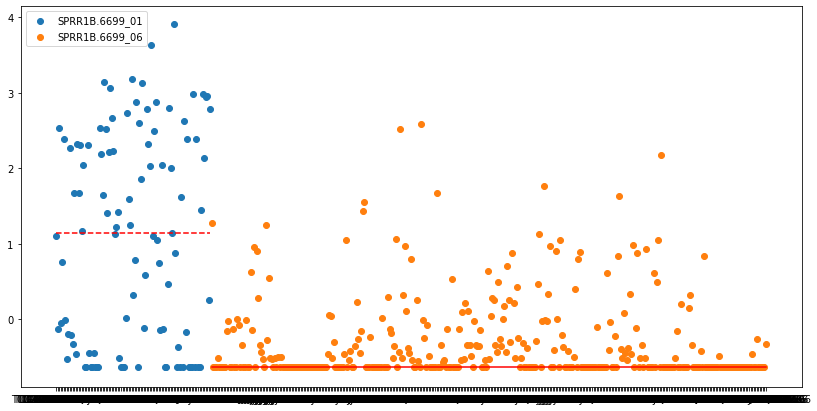

In [211]:
# Examples #1 (genes)
graph(7, genes_found_data_01, genes_found_data_06, dataframes['gene_data_medians'], gene_axis)

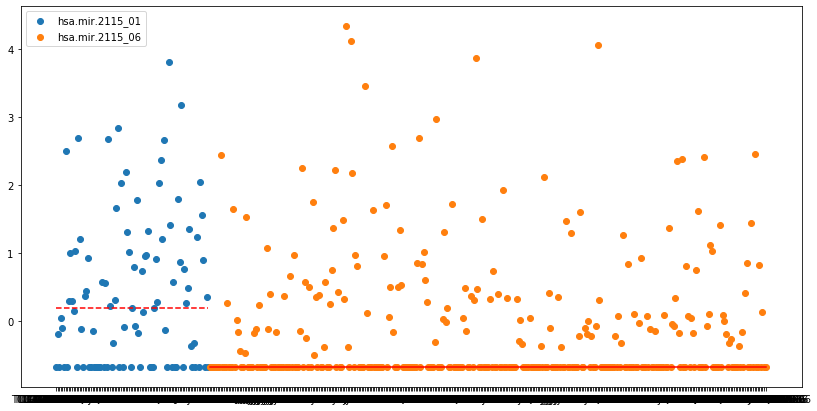

In [213]:
# Examples #2 (mirna)
graph(9, mirna_found_data_01, mirna_found_data_06, dataframes['micro_rna_data_medians'], mirna_axis)

In [120]:
a

gene       A1BG.1  A2BP1.54715  A2LD1.87769  A2ML1.144568       A2M.2  \
count  103.000000   103.000000   103.000000    103.000000  103.000000   
mean     0.378261     0.024405     0.171843      0.882802   -0.203643   
std      0.995113     1.196498     0.982136      1.374454    1.011969   
min     -2.848987    -0.413046    -2.642376     -0.711574   -2.469226   
25%     -0.189153    -0.413046    -0.486723     -0.494719   -1.013283   
50%      0.427778    -0.413046     0.262644      0.577061   -0.140232   
75%      0.765849     0.180345     0.773233      2.185779    0.418892   
max      3.559694    10.414313     2.446470      3.521356    2.597457   

gene   A4GALT.53947  AACSL.729522  AADACL2.344752  AADACL3.126767    AADAC.13  \
count    103.000000    103.000000      103.000000      103.000000  103.000000   
mean      -0.059610     -0.009605        0.863875        0.162625    0.185089   
std        0.834389      0.945949        1.712641        1.311751    1.155560   
min       -1.882601     -0.638516       -0.343631       -0.161609   -0.536844   
25%       -0.652287     -0.638516       -0.343631       -0.161609   -0.536844   
50%       -0.176333     -0.398863       -0.343631       -0.161609   -0.536844   
75%        0.480880      0.088286        2.006625       -0.161609    0.484351   
max        1.868523      3.429139        5.150912        8.723813    4.333063   

gene   ...  ZSCAN18.65982  ZSCAN1.284312  ZSCAN23.222696  ZSCAN4.201516  \
count  ...     103.000000     103.000000      103.000000     103.000000   
mean   ...      -0.174195      -0.074380       -0.188071       0.238569   
std    ...       1.060225       1.043196        0.951828       1.186912   
min    ...      -2.125369      -0.695362       -1.358739      -0.645632   
25%    ...      -0.985797      -0.695362       -1.001640      -0.645632   
50%    ...      -0.190763      -0.695362       -0.308988      -0.148302   
75%    ...       0.776524       0.153822        0.587873       0.689080   
max    ...       2.037600       4.393101        1.876838       4.848070   

gene   ZSCAN5A.79149  ZSCAN5B.342933  ZSWIM5.57643  ZUFSP.221302  \
count     103.000000      103.000000    103.000000    103.000000   
mean       -0.001514       -0.101186      0.028260     -0.173722   
std         0.969624        0.957181      1.023491      1.055943   
min        -3.380122       -1.159337     -2.314990     -3.953697   
25%        -0.609698       -0.954955     -0.547402     -0.670385   
50%         0.050553       -0.174877      0.199847     -0.058199   
75%         0.445972        0.408806      0.817257      0.568332   
max         2.885078        3.800676      1.656061      2.016407   

gene   ZYG11A.440590  psiTPTE22.387590  
count     103.000000        103.000000  
mean       -0.063916          0.142298  
std         0.971523          1.195236  
min        -0.987508         -2.021106  
25%        -0.700311         -0.635876  
50%        -0.338132         -0.152152  
75%         0.191782          0.744493  
max         2.918146          3.907706  

[8 rows x 10650 columns]

In [52]:
len(dataframes['gene_data_01'].columns)

10650

In [56]:
dataframes['gene_data_01'].index

Index(['TCGA.BF.A1PU.01', 'TCGA.BF.A1PV.01', 'TCGA.BF.A1PX.01',
       'TCGA.BF.A1PZ.01', 'TCGA.BF.A1Q0.01', 'TCGA.BF.A3DJ.01',
       'TCGA.BF.A3DL.01', 'TCGA.BF.A3DM.01', 'TCGA.BF.A3DN.01',
       'TCGA.BF.A5EO.01',
       ...
       'TCGA.HR.A5NC.01', 'TCGA.IH.A3EA.01', 'TCGA.WE.A8K4.01',
       'TCGA.XV.A9VZ.01', 'TCGA.XV.A9W2.01', 'TCGA.XV.A9W5.01',
       'TCGA.XV.AAZV.01', 'TCGA.XV.AAZW.01', 'TCGA.XV.AAZY.01',
       'TCGA.YG.AA3N.01'],
      dtype='object', length=103)

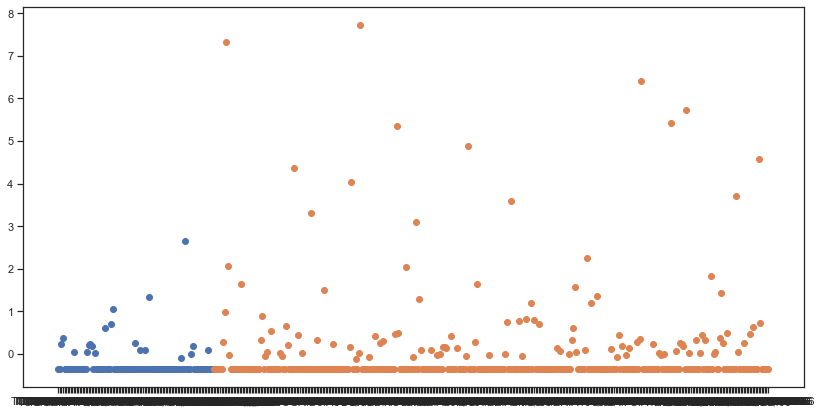

In [121]:
#interresting: 3

y = range(int(min_val_b-10) , int(max_val_b+10))
fig = plt.figure(figsize=(14,7))
ax2 = plt.subplot(1, 1, 1)
#for x in range(10):
#for x in range(100):
#for x in range(10650):
x = 1000
ax2.scatter(dataframes['gene_data_01'].index, dataframes['gene_data_01'].iloc[:, x], label=dataframes['gene_data_01'].columns[x])
ax2.scatter(dataframes['gene_data_06'].index, dataframes['gene_data_06'].iloc[:, x], label=dataframes['gene_data_06'].columns[x])
#plt.legend(loc='upper left');
plt.show()



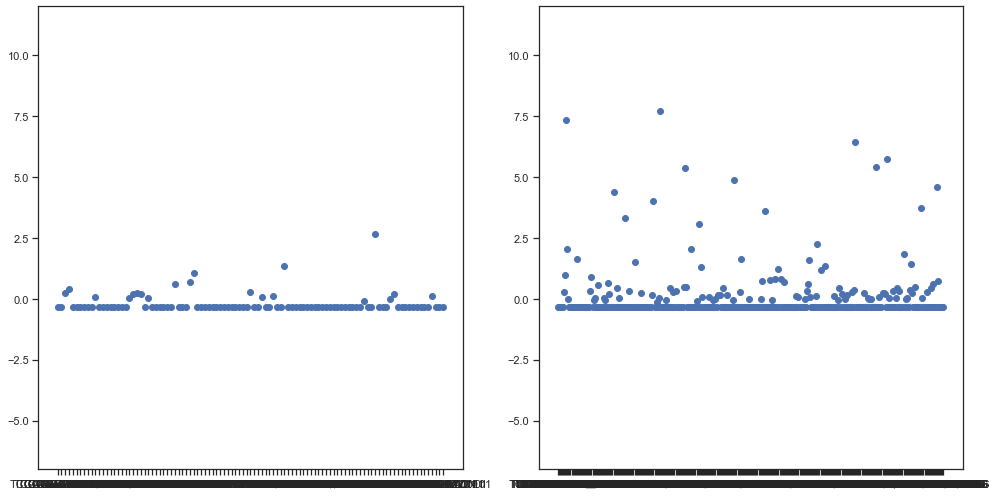

In [122]:
#interresting: 3

y = range(int(min_val_a-10) , int(max_val_a+10))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].set_ylim(int(min_val_a), int(max_val_a))
axes[1].set_ylim(int(min_val_a), int(max_val_a))
#for x in range(10):
x = 1000
axes[0].scatter(dataframes['gene_data_01'].index, dataframes['gene_data_01'].iloc[:, x], label=dataframes['gene_data_01'].columns[x])
axes[1].scatter(dataframes['gene_data_06'].index, dataframes['gene_data_06'].iloc[:, x], label=dataframes['gene_data_06'].columns[x])
fig.tight_layout()

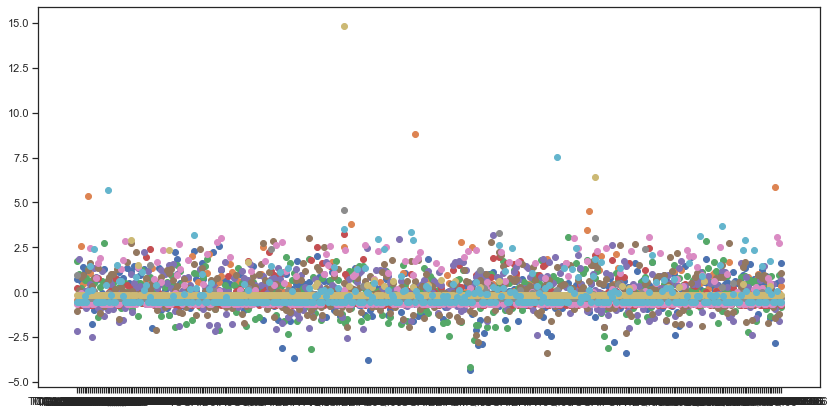

In [101]:
y = range(int(min_val_b-10) , int(max_val_b+10))
fig = plt.figure(figsize=(14,7))
ax2 = plt.subplot(1, 1, 1)
#ax1 = fig.add_subplot(111)
for x in range(10):
#for x in range(100):
#for x in range(10650):
    ax2.scatter(dataframes['gene_data_06'].index, dataframes['gene_data_06'].iloc[:, x], label=dataframes['gene_data_06'].columns[x])
#plt.legend(loc='upper left');
plt.show()


12.23149296065022

In [ ]:
# graph should be:



In [29]:
dataframes['gene_data_01'].to_excel("gene_data_01.xlsx")

In [30]:
dataframes['gene_data_06'] = dataframes['gene_data_06'].fillna(0)
dataframes['gene_data_06'].to_excel("gene_data_06.xlsx")

In [98]:
#create one dataset for 06 and one for 01
#a = dataframes['gene_data'][dataframes['gene_data'].name[-2:] == "06"]
df_06 = dataframes['gene_data'].filter(regex='.06$|gene',axis=1)
df_01 = dataframes['gene_data'].filter(regex='.01$|gene',axis=1)

df_06 = df_06.T # transpose
df_06.columns = df_06.iloc[0, :] # use first row as column names
df_06 = df_06.iloc[1:, :]
df_06.head()

gene              A1BG.1 A1CF.29974 A2BP1.54715 A2LD1.87769 A2ML1.144568  \
TCGA.3N.A9WB.06  381.066          0           0     250.198       7.2698   
TCGA.3N.A9WC.06  195.182          0           0     160.755            0   
TCGA.3N.A9WD.06  360.879     0.7092       6.383     97.1986            0   
TCGA.BF.AAP0.06  609.726          0      0.8045     54.1191       0.8045   
TCGA.D3.A1Q1.06  499.219          0           0     129.717       0.3582   

gene               A2M.2 A4GALT.53947 A4GNT.51146 AAA1.404744 AAAS.8086  ...  \
TCGA.3N.A9WB.06  2209.52      33.5218           0           0   964.863  ...   
TCGA.3N.A9WC.06   169237      105.189      1.2045           0   722.272  ...   
TCGA.3N.A9WD.06  18257.9          200           0           0   668.794  ...   
TCGA.BF.AAP0.06  23157.6      229.284       1.609           0   1202.74  ...   
TCGA.D3.A1Q1.06  23780.4      58.7393           0           0   1131.81  ...   

gene            ZUFSP.221302 ZW10.9183 ZWILCH.55055 ZWINT.11130 ZYG11A.440590  \
TCGA.3N.A9WB.06      99.3538   370.759      507.654     1418.42        7.2698   
TCGA.3N.A9WC.06      111.613   236.073       423.13     434.006         0.803   
TCGA.3N.A9WD.06      114.894   448.227      213.135     423.404       15.6028   
TCGA.BF.AAP0.06      118.262   256.235      572.345     654.867        2.0113   
TCGA.D3.A1Q1.06      108.882   434.814      423.388      257.88        1.0745   

gene            ZYG11B.79699 ZZEF1.23140 ZZZ3.26009 psiTPTE22.387590  \
TCGA.3N.A9WB.06      644.588     622.779    721.325           2.8271   
TCGA.3N.A9WC.06      690.154      883.67    1137.81           4.8178   
TCGA.3N.A9WD.06      849.645     1105.67    769.504          197.163   
TCGA.BF.AAP0.06      383.749      1143.2    444.891           5.2293   
TCGA.D3.A1Q1.06      770.057     1791.91    1346.35          12.1777   

gene            tAKR.389932  
TCGA.3N.A9WB.06           0  
TCGA.3N.A9WC.06      0.4015  
TCGA.3N.A9WD.06           0  
TCGA.BF.AAP0.06      0.8045  
TCGA.D3.A1Q1.06           0  

[5 rows x 19363 columns]

gene              A1BG.1 A1CF.29974 A2BP1.54715 A2LD1.87769 A2ML1.144568  \
TCGA.3N.A9WB.06  381.066          0           0     250.198       7.2698   
TCGA.3N.A9WC.06  195.182          0           0     160.755            0   
TCGA.3N.A9WD.06  360.879     0.7092       6.383     97.1986            0   
TCGA.BF.AAP0.06  609.726          0      0.8045     54.1191       0.8045   
TCGA.D3.A1Q1.06  499.219          0           0     129.717       0.3582   

gene               A2M.2 A4GALT.53947 A4GNT.51146 AAA1.404744 AAAS.8086  ...  \
TCGA.3N.A9WB.06  2209.52      33.5218           0           0   964.863  ...   
TCGA.3N.A9WC.06   169237      105.189      1.2045           0   722.272  ...   
TCGA.3N.A9WD.06  18257.9          200           0           0   668.794  ...   
TCGA.BF.AAP0.06  23157.6      229.284       1.609           0   1202.74  ...   
TCGA.D3.A1Q1.06  23780.4      58.7393           0           0   1131.81  ...   

gene            ZUFSP.221302 ZW10.9183 ZWILCH.55055 ZWINT.11130 ZYG11A.440590  \
TCGA.3N.A9WB.06      99.3538   370.759      507.654     1418.42        7.2698   
TCGA.3N.A9WC.06      111.613   236.073       423.13     434.006         0.803   
TCGA.3N.A9WD.06      114.894   448.227      213.135     423.404       15.6028   
TCGA.BF.AAP0.06      118.262   256.235      572.345     654.867        2.0113   
TCGA.D3.A1Q1.06      108.882   434.814      423.388      257.88        1.0745   

gene            ZYG11B.79699 ZZEF1.23140 ZZZ3.26009 psiTPTE22.387590  \
TCGA.3N.A9WB.06      644.588     622.779    721.325           2.8271   
TCGA.3N.A9WC.06      690.154      883.67    1137.81           4.8178   
TCGA.3N.A9WD.06      849.645     1105.67    769.504          197.163   
TCGA.BF.AAP0.06      383.749      1143.2    444.891           5.2293   
TCGA.D3.A1Q1.06      770.057     1791.91    1346.35          12.1777   

gene            tAKR.389932  
TCGA.3N.A9WB.06           0  
TCGA.3N.A9WC.06      0.4015  
TCGA.3N.A9WD.06           0  
TCGA.BF.AAP0.06      0.8045  
TCGA.D3.A1Q1.06           0  

[5 rows x 19363 columns]

Clustering

In [148]:
# transpose gene data, micro rna data

#transpose_data = [dataframes['gene_data'], dataframes['micro_rna_data']]

a = dataframes['gene_data'].T # transpose
a.columns = a.iloc[0, :] # use first row as column names
a = a.iloc[1:, :]
a.columns
# a.rename(columns={" gene ": "patient"})



Index(['A1BG.1', 'A1CF.29974', 'A2BP1.54715', 'A2LD1.87769', 'A2ML1.144568',
       'A2M.2', 'A4GALT.53947', 'A4GNT.51146', 'AAA1.404744', 'AAAS.8086',
       ...
       'ZUFSP.221302', 'ZW10.9183', 'ZWILCH.55055', 'ZWINT.11130',
       'ZYG11A.440590', 'ZYG11B.79699', 'ZZEF1.23140', 'ZZZ3.26009',
       'psiTPTE22.387590', 'tAKR.389932'],
      dtype='object', name='gene', length=19363)

In [91]:
# sample gene data
dataframes['gene_data'].head()

29          30           31           32            33     \
gene               A1BG.1  A1CF.29974  A2BP1.54715  A2LD1.87769  A2ML1.144568   
TCGA.3N.A9WB.06  0.705057   -0.280646    -0.413046      1.75705      0.221882   
TCGA.3N.A9WC.06 -0.271497   -0.280646    -0.413046      1.03622     -0.711574   
TCGA.3N.A9WD.06  0.625527     1.58431      2.57894     0.218885     -0.711574   
TCGA.BF.A1PU.01 -0.418943   -0.280646     0.832644      1.06113      0.248948   

                    34            35           36           37         38     \
gene                A2M.2  A4GALT.53947  A4GNT.51146  AAA1.404744  AAAS.8086   
TCGA.3N.A9WB.06  -2.15541      -1.05048    -0.991263    -0.150562     0.1785   
TCGA.3N.A9WC.06   1.85513      0.141679     0.669905    -0.150562  -0.649788   
TCGA.3N.A9WD.06 -0.203402      0.818677    -0.991263    -0.150562  -0.869765   
TCGA.BF.A1PU.01  -1.12785      0.451753    0.0603083    -0.150562 -0.0433683   

                 ...         20517      20518         20519        20520  \
gene             ...  ZUFSP.221302  ZW10.9183  ZWILCH.55055  ZWINT.11130   
TCGA.3N.A9WB.06  ...     -0.146231   0.116896       0.28618      1.52303   
TCGA.3N.A9WC.06  ...     0.0501261  -0.973146    -0.0479013      -0.5587   
TCGA.3N.A9WD.06  ...     0.0990477   0.575522       -1.3043     -0.60213   
TCGA.BF.A1PU.01  ...     0.0852827  -0.980146    -0.0663148    -0.091513   

                         20524         20525        20527       20528  \
gene             ZYG11A.440590  ZYG11B.79699  ZZEF1.23140  ZZZ3.26009   
TCGA.3N.A9WB.06       0.973086     -0.253298     -2.23982  -0.0997414   
TCGA.3N.A9WC.06      -0.440471     -0.120323     -1.23257    0.702474   
TCGA.3N.A9WD.06         1.6199      0.284513     -0.58714   0.0140356   
TCGA.BF.A1PU.01      -0.987508      -1.01398     0.810425    -1.72589   

                            20529        20530  
gene             psiTPTE22.387590  tAKR.389932  
TCGA.3N.A9WB.06         -0.878129    -0.284935  
TCGA.3N.A9WC.06         -0.521455      2.52572  
TCGA.3N.A9WD.06           2.48323    -0.284935  
TCGA.BF.A1PU.01         -0.930842    -0.284935  

[5 rows x 19363 columns]

In [70]:
# sample mirna data
dataframes['micro_rna_data'].head()

micro_rna  TCGA.3N.A9WC.06  TCGA.3N.A9WD.06  TCGA.BF.A1PU.01  \
0  hsa.let.7a.1         0.237300         1.413978         1.265548   
1  hsa.let.7a.2         0.222888         1.409208         1.264947   
2  hsa.let.7a.3         0.224394         1.418898         1.265640   
3    hsa.let.7b        -0.225533         0.833381         1.430398   
4    hsa.let.7c        -1.571869         2.179965         0.263552   

   TCGA.BF.A1PV.01  TCGA.BF.A1PX.01  TCGA.BF.A1PZ.01  TCGA.BF.A1Q0.01  \
0         0.185478         0.094122         0.451664        -0.571239   
1         0.179001         0.110415         0.445268        -0.566822   
2         0.156424         0.112991         0.443217        -0.583000   
3        -0.259191         1.310078        -0.237814        -0.933001   
4         0.220736         0.877972        -0.190870        -0.491599   

   TCGA.BF.A3DJ.01  TCGA.BF.A3DL.01  ...  TCGA.XV.AB01.06  TCGA.YD.A89C.06  \
0         0.519428         2.149726  ...        -0.528080        -2.190976   
1         0.545780         2.146487  ...        -0.535880        -2.168277   
2         0.563999         2.142916  ...        -0.559339        -2.178939   
3         0.950472         1.836045  ...        -0.496495        -3.250218   
4        -1.763443         0.910929  ...        -1.462939        -2.789086   

   TCGA.YD.A9TA.06  TCGA.YD.A9TB.06  TCGA.YG.AA3N.01  TCGA.YG.AA3O.06  \
0        -0.647503        -1.113845        -0.000021        -0.112561   
1        -0.645517        -1.087783         0.004459        -0.119957   
2        -0.656756        -1.098432        -0.006949        -0.150725   
3        -0.958898        -0.349975        -0.638938        -0.291756   
4        -1.046594         0.552762         0.439090        -0.992765   

   TCGA.YG.AA3P.06  TCGA.Z2.A8RT.06  TCGA.Z2.AA3S.06  TCGA.Z2.AA3V.06  
0         1.255562        -0.427824        -0.161147         1.307661  
1         1.251081        -0.437552        -0.159200         1.300205  
2         1.272062        -0.431599        -0.102585         1.309069  
3        -0.757145        -1.016035        -3.003734         0.182476  
4         2.218663        -1.160461         0.211481        -0.196613  

[5 rows x 453 columns]

In [71]:
dataframes['gtex_data'].head()

ensemble_id  GTEX-111YS-0006-SM-5NQBE  GTEX-1122O-0005-SM-5O99J  \
0  "ENSG00000227232"                 -0.169609                  0.054703   
1  "ENSG00000238009"                 -0.268123                  0.129532   
2  "ENSG00000233750"                 -0.168988                 -0.183577   
3  "ENSG00000237683"                 -0.015901                 -0.114264   
4  "ENSG00000268903"                  0.033084                 -0.136116   

   GTEX-1128S-0005-SM-5P9HI  GTEX-113IC-0006-SM-5NQ9C  \
0                  0.009834                  0.062832   
1                 -0.226318                 -0.594374   
2                 -0.164673                 -0.587763   
3                  0.273116                 -0.442626   
4                  0.357690                 -0.209781   

   GTEX-113JC-0006-SM-5O997  GTEX-117XS-0005-SM-5PNU6  \
0                 -0.111598                  0.013749   
1                 -0.247985                  0.440750   
2                 -0.170246                  0.177095   
3                 -0.249558                  0.040346   
4                 -1.040812                  0.290923   

   GTEX-117YW-0005-SM-5NQ8Z  GTEX-1192W-0005-SM-5NQBQ  \
0                  0.059378                 -0.103492   
1                  0.012203                  0.023756   
2                  0.092399                  0.186742   
3                  0.092957                  0.060168   
4                 -0.224477                 -0.395459   

   GTEX-11DXW-0006-SM-5NQ7Y  ...  GTEX-ZVE2-0006-SM-51MRW  \
0                 -0.056906  ...                -0.135461   
1                  0.023010  ...                -0.233336   
2                  0.050464  ...                -0.647793   
3                  0.024587  ...                -0.200647   
4                  0.080350  ...                -0.395148   

   GTEX-ZVP2-0005-SM-51MRK  GTEX-ZVT2-0005-SM-57WBW  GTEX-ZVT3-0006-SM-51MT9  \
0                 0.031812                -0.033919                -0.083926   
1                -0.041431                 0.150914                 0.142757   
2                -0.179416                -0.039154                -0.157434   
3                -0.036321                 0.093315                -0.097231   
4                 0.019980                 0.151770                 0.050996   

   GTEX-ZVT4-0006-SM-57WB8  GTEX-ZVTK-0006-SM-57WBK  GTEX-ZVZP-0006-SM-51MSW  \
0                 0.057796                -0.026684                 0.076550   
1                 0.181792                -0.067478                 0.196848   
2                -0.072724                 0.008101                 0.326528   
3                 0.055875                -0.226099                -0.198103   
4                 0.102515                -0.360847                -0.076868   

   GTEX-ZVZQ-0006-SM-51MR8  GTEX-ZXES-0005-SM-57WCB  GTEX-ZXG5-0005-SM-57WCN  
0                 0.074503                -0.024322                 0.008076  
1                 0.086229                -0.274816                -0.030805  
2                -0.103061                -0.018962                -0.099040  
3                -0.151890                -0.091329                -0.023483  
4                 0.020539                -0.067300                 0.040908  

[5 rows x 394 columns]

In [73]:
# sample survival data
dataframes['survival_data'].head()

PatientID  Survival  isDead
0  TCGA-3N-A9WB-06     518.0     1.0
1  TCGA-3N-A9WC-06    2022.0     0.0
2  TCGA-3N-A9WD-06     395.0     1.0
3  TCGA-BF-A1PU-01     387.0     0.0
4  TCGA-BF-A1PV-01      14.0     0.0

In [74]:
# load clinical data data

"""
loading with python or excel: problem with rwos 38, 39!!

the data has a problem in line 38, 39:
they are series with 3 elements (total values: 105, unlike total 103 in other rows)
we discluded this data

we tried to load this data with RStudio but it didnt work
"""

clinical_titles = pd.read_csv('melanoma.txt', header=None, nrows=1) 
clinical_data_titles = clinical_titles.iloc[0, 0].split('\t')

clinical_data = pd.read_csv('melanoma.txt', header=None, names=clinical_data_titles, skiprows=[0, 38,39], sep='\t') 

dataframes['clinical_data'] = clinical_data

In [75]:
#sample clinical data
dataframes['clinical_data'].head()

sampleID  _EVENT     _INTEGRATION     _OS  _OS_IND _OS_UNIT  \
0  TCGA-3N-A9WB-06     1.0  TCGA-3N-A9WB-06   518.0      1.0     days   
1  TCGA-3N-A9WC-06     0.0  TCGA-3N-A9WC-06  2022.0      0.0     days   
2  TCGA-3N-A9WD-06     1.0  TCGA-3N-A9WD-06   395.0      1.0     days   
3  TCGA-BF-A1PU-01     0.0  TCGA-BF-A1PU-01   387.0      0.0     days   
4  TCGA-BF-A1PV-01     0.0  TCGA-BF-A1PV-01    14.0      0.0     days   

       _PATIENT    _RFS  _RFS_IND _RFS_UNIT  ...  \
0  TCGA-3N-A9WB     NaN       NaN      days  ...   
1  TCGA-3N-A9WC  2022.0       0.0      days  ...   
2  TCGA-3N-A9WD     NaN       NaN      days  ...   
3  TCGA-BF-A1PU     NaN       NaN      days  ...   
4  TCGA-BF-A1PV    14.0       0.0      days  ...   

   _GENOMIC_ID_data/public/TCGA/SKCM/miRNA_HiSeq_gene  \
0                                                NaN    
1                                    TCGA-3N-A9WC-06    
2                                    TCGA-3N-A9WD-06    
3                                    TCGA-BF-A1PU-01    
4                                    TCGA-BF-A1PV-01    

             _GENOMIC_ID_TCGA_SKCM_RPPA  \
0                                   NaN   
1  F9B0B31B-24AB-4F30-8EF8-4A4ED282EF04   
2  6AFC3678-9499-49A6-AD7A-30F3D185B4BD   
3  7E74CAFD-C47B-4F98-A349-BBD2AC699D2D   
4                                   NaN   

  _GENOMIC_ID_TCGA_SKCM_mutation_bcm_gene  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3            TCGA-BF-A1PU-01A-11D-A19A-08   
4            TCGA-BF-A1PV-01A-11D-A19A-08   

  _GENOMIC_ID_TCGA_SKCM_mutation_broad_gene _GENOMIC_ID_TCGA_SKCM_gistic2  \
0              TCGA-3N-A9WB-06A-11D-A38G-08  TCGA-3N-A9WB-06A-11D-A38F-01   
1              TCGA-3N-A9WC-06A-11D-A38G-08  TCGA-3N-A9WC-06A-11D-A38F-01   
2              TCGA-3N-A9WD-06A-11D-A38G-08  TCGA-3N-A9WD-06A-11D-A38F-01   
3              TCGA-BF-A1PU-01A-11D-A19A-08                           NaN   
4              TCGA-BF-A1PV-01A-11D-A19A-08                           NaN   

  _GENOMIC_ID_TCGA_SKCM_mutation _GENOMIC_ID_TCGA_SKCM_exp_HiSeqV2_exon  \
0                            NaN   4c243ea9-dfe1-42f0-a887-3c901fb38542   
1                            NaN   a64ae1f5-a189-4173-be13-903bd7637869   
2                            NaN   ac19f7cf-670b-4dcc-a26b-db0f56377231   
3   TCGA-BF-A1PU-01A-11D-A19A-08   9ff4d588-da73-4e26-975d-2b098fe74984   
4   TCGA-BF-A1PV-01A-11D-A19A-08   a57841bb-fa68-4d84-85e0-2d5e4f3ce828   

   _GENOMIC_ID_TCGA_SKCM_PDMRNAseqCNV _GENOMIC_ID_TCGA_SKCM_PDMRNAseq  \
0                                 NaN                             NaN   
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4                                 NaN                             NaN   

  _GENOMIC_ID_TCGA_SKCM_exp_HiSeqV2_percentile  
0         4c243ea9-dfe1-42f0-a887-3c901fb38542  
1         a64ae1f5-a189-4173-be13-903bd7637869  
2         ac19f7cf-670b-4dcc-a26b-db0f56377231  
3         9ff4d588-da73-4e26-975d-2b098fe74984  
4         a57841bb-fa68-4d84-85e0-2d5e4f3ce828  

[5 rows x 103 columns]

In [ ]:
#Option 1: cluster all features

In [82]:
# dealing with nulls
#dataframes['micro_rna_data']['TCGA.BF.A1PV.01'].isnull

dataframes['micro_rna_data'].loc[dataframes['micro_rna_data']['TCGA.BF.A1PV.01'].isnull()].shape

(145, 453)